# Homework 11 - Transfer Learning (Domain Adversarial Training)

> Author: Arvin Liu (r09922071@ntu.edu.tw)

If there are any questions, please contact mlta-2022-spring@googlegroups.com

# Readme

In homework 11, you will need to implement Domain Adversarial Training in Transfer Learning. As shown in the bottom left part of the figure.

<img src="https://i.imgur.com/iMVIxCH.png" width="500px">

> 

## Scenario and Why Domain Adversarial Training
Now we have labeled source data and unlabeled target data, where source data might be relavent to the target data. We now want to train a model with source data only and test it on target data.

What problem might occur if we do so? After we have learned Anomaly Detection, we now know that if we test the model with an abnormal data that have never appeared in source data, our trained model is likely to result in poor performance since it is not familiar with the abnormal data.

For example, we have a model that contains Feature Extractor and Classifier:
<img src="https://i.imgur.com/IL0PxCY.png" width="500px">

When the model is trained with source data, the feature extractor 
will extract meaningful features since it is familiar with the distribution of it.It could be seen in the following figure that the blue dots, which is the distribution of source data, has already been clustered into different clusters. Therefore, the Classifier can predict the label based on these clusters.

However, when test on the target data, the Feature Extractor will not be able to extract meaningful features that follow the distribution of the source feature distribution, which result in the classifier learned for the source domain will not be able to apply to the target domain.


## Domain Adversarial Training of Nerural Networks (DaNN)

Based on the above problems, DaNN approaches build mappings between the source (training-time) and the target (test-time) domains, so that the classifier learned for the source domain can also be applied to the target domain, when composed with the learned mapping between domains.

<img src="https://i.imgur.com/vrOE5a6.png" width="500px">

In DaNN, the authors added a Domain Classifier, which is a deep discriminatively-trained classifeir in the training framework to distinguish the data from different domain by the features extracted by the feature extractor. As the training progresses, the approach promotes a domain classifier that discriminates between the source and the target domains and a feature extractor that can extractor features that are discriminative for the main learning task on the source domain and indiscriminate with respect to the shift between the domains. 


The feature extractor are likely to outperform the domain classifier as its input are generated by the feature extractor and that the task of domain classification and label classification are not conflict.

This method leads to the emergence of features that are domain-invariant and on the same feature distribution.

# Data Introduce

Our task contains source data: real photos, and target data: hand-drawn graffiti.

We are going to train the model with the photos and the labels, and try to predict what the labels are for hand-drawn graffiti.

The data could be downloaded [here](https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip). The code below is for data downloading and visualization.

Note that: **The source and target data are all balanced data, you can make use of this information.**

In [2]:
!nvidia-smi

Thu May 19 01:42:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Download dataset
!wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.0/real_or_drawing.zip" -O real_or_drawing.zip

# Download from mirrored dataset link
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.1/real_or_drawing.zip" -O real_or_drawing.zip
# !wget "https://github.com/redxouls/ml2020spring-hw11-dataset/releases/download/v1.0.2/real_or_drawing.zip" -O real_or_drawing.zip

# Unzip the files
!unzip real_or_drawing.zip

Streaming output truncated to the last 5000 lines.
  inflating: real_or_drawing/train_data/0/106.bmp  
  inflating: real_or_drawing/train_data/0/107.bmp  
  inflating: real_or_drawing/train_data/0/108.bmp  
  inflating: real_or_drawing/train_data/0/109.bmp  
  inflating: real_or_drawing/train_data/0/11.bmp  
  inflating: real_or_drawing/train_data/0/110.bmp  
  inflating: real_or_drawing/train_data/0/111.bmp  
  inflating: real_or_drawing/train_data/0/112.bmp  
  inflating: real_or_drawing/train_data/0/113.bmp  
  inflating: real_or_drawing/train_data/0/114.bmp  
  inflating: real_or_drawing/train_data/0/115.bmp  
  inflating: real_or_drawing/train_data/0/116.bmp  
  inflating: real_or_drawing/train_data/0/117.bmp  
  inflating: real_or_drawing/train_data/0/118.bmp  
  inflating: real_or_drawing/train_data/0/119.bmp  
  inflating: real_or_drawing/train_data/0/12.bmp  
  inflating: real_or_drawing/train_data/0/120.bmp  
  inflating: real_or_drawing/train_data/0/121.bmp  
  inflating: re

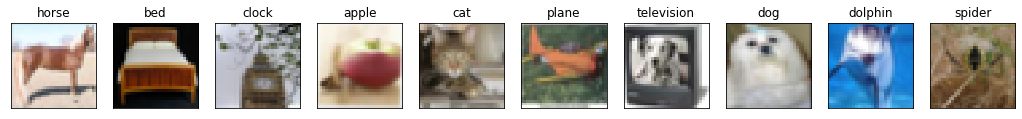

In [4]:
import matplotlib.pyplot as plt

def no_axis_show(img, title='', cmap=None):
  # imshow, and set the interpolation mode to be "nearest"。
  fig = plt.imshow(img, interpolation='nearest', cmap=cmap)
  # do not show the axes in the images.
  fig.axes.get_xaxis().set_visible(False)
  fig.axes.get_yaxis().set_visible(False)
  plt.title(title)

titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/train_data/{i}/{500*i}.bmp'), title=titles[i])

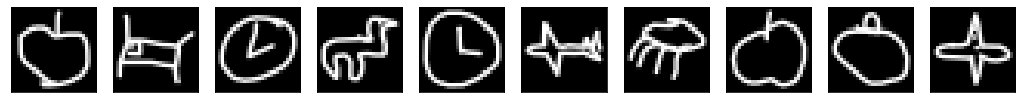

In [5]:
plt.figure(figsize=(18, 18))
for i in range(10):
  plt.subplot(1, 10, i+1)
  fig = no_axis_show(plt.imread(f'real_or_drawing/test_data/0/' + str(i).rjust(5, '0') + '.bmp'))

# Special Domain Knowledge

When we graffiti, we usually draw the outline only, therefore we can perform edge detection processing on the source data to make it more similar to the target data.


## Canny Edge Detection
The implementation of Canny Edge Detection is as follow.
The algorithm will not be describe thoroughly here.  If you are interested, please refer to the wiki or [here](https://medium.com/@pomelyu5199/canny-edge-detector-%E5%AF%A6%E4%BD%9C-opencv-f7d1a0a57d19).

We only need two parameters to implement Canny Edge Detection with CV2:  `low_threshold` and `high_threshold`.

```cv2.Canny(image, low_threshold, high_threshold)```

Simply put, when the edge value exceeds the high_threshold, we determine it as an edge. If the edge value is only above low_threshold, we will then determine whether it is an edge or not.

Let's implement it on the source data.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  from ipykernel import kernelapp as app


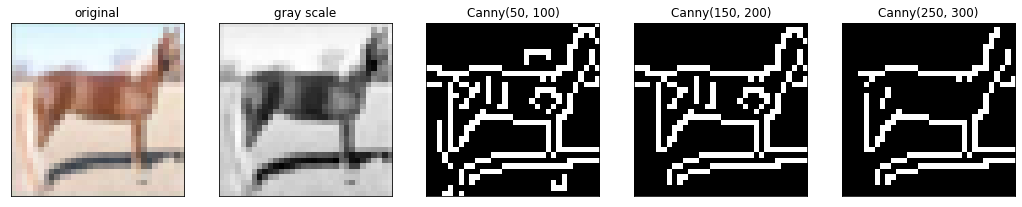

In [6]:
import cv2
import matplotlib.pyplot as plt
titles = ['horse', 'bed', 'clock', 'apple', 'cat', 'plane', 'television', 'dog', 'dolphin', 'spider']
plt.figure(figsize=(18, 18))

original_img = plt.imread(f'real_or_drawing/train_data/0/0.bmp')
plt.subplot(1, 5, 1)
no_axis_show(original_img, title='original')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

gray_img = cv2.cvtColor(original_img, cv2.COLOR_RGB2GRAY)
plt.subplot(1, 5, 2)
no_axis_show(gray_img, title='gray scale', cmap='gray')

canny_50100 = cv2.Canny(gray_img, 50, 100)
plt.subplot(1, 5, 3)
no_axis_show(canny_50100, title='Canny(50, 100)', cmap='gray')

canny_150200 = cv2.Canny(gray_img, 150, 200)
plt.subplot(1, 5, 4)
no_axis_show(canny_150200, title='Canny(150, 200)', cmap='gray')

canny_250300 = cv2.Canny(gray_img, 250, 300)
plt.subplot(1, 5, 5)
no_axis_show(canny_250300, title='Canny(250, 300)', cmap='gray')
  

# Data Process
 
 
The data is suitible for `torchvision.ImageFolder`. You can create a dataset with `torchvision.ImageFolder`. Details for image augmentation please refer to the comments in the following codes.

In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function
 
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
 
source_transform = transforms.Compose([
    # Turn RGB to grayscale. (Bacause Canny do not support RGB images.)
    transforms.Grayscale(),
    # cv2 do not support skimage.Image, so we transform it to np.array, 
    # and then adopt cv2.Canny algorithm.
    transforms.Lambda(lambda x: cv2.Canny(np.array(x), 170, 300)),
    # Transform np.array back to the skimage.Image.
    transforms.ToPILImage(),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
target_transform = transforms.Compose([
    # Turn RGB to grayscale.
    transforms.Grayscale(),
    # Resize: size of source data is 32x32, thus we need to 
    #  enlarge the size of target data from 28x28 to 32x32。
    transforms.Resize((32, 32)),
    # 50% Horizontal Flip. (For Augmentation)
    transforms.RandomHorizontalFlip(),
    # Rotate +- 15 degrees. (For Augmentation), and filled with zero 
    # if there's empty pixel after rotation.
    transforms.RandomRotation(15, fill=(0,)),
    # Transform to tensor for model inputs.
    transforms.ToTensor(),
])
 
source_dataset = ImageFolder('real_or_drawing/train_data', transform=source_transform)
target_dataset = ImageFolder('real_or_drawing/test_data', transform=target_transform)
 
source_dataloader = DataLoader(source_dataset, batch_size=32, shuffle=True)
target_dataloader = DataLoader(target_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(target_dataset, batch_size=128, shuffle=False)

# Model

Feature Extractor: Classic VGG-like architecture

Label Predictor / Domain Classifier: Linear models.

In [8]:
class FeatureExtractor(nn.Module):

    def __init__(self):
        super(FeatureExtractor, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, 3, 1, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, 3, 1, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(128, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, 1, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 512, 3, 1, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
    def forward(self, x):
        x = self.conv(x).squeeze()
        return x

class LabelPredictor(nn.Module):

    def __init__(self):
        super(LabelPredictor, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )

    def forward(self, h):
        c = self.layer(h)
        return c

class DomainClassifier(nn.Module):

    def __init__(self):
        super(DomainClassifier, self).__init__()

        self.layer = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 1),
        )

    def forward(self, h):
        y = self.layer(h)
        return y

# Pre-processing

Here we use Adam as our optimizor.

In [9]:
feature_extractor = FeatureExtractor().cuda()
label_predictor = LabelPredictor().cuda()
domain_classifier = DomainClassifier().cuda()

class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.BCEWithLogitsLoss()

lr = 5e-4
optimizer_F = optim.AdamW(feature_extractor.parameters(), lr=lr)
optimizer_C = optim.AdamW(label_predictor.parameters(), lr=lr)
optimizer_D = optim.AdamW(domain_classifier.parameters(), lr=lr)

# Start Training


## DaNN Implementation

In the original paper, Gradient Reversal Layer is used.
Feature Extractor, Label Predictor, and Domain Classifier are all trained at the same time. In this code, we train Domain Classifier first, and then train our Feature Extractor (same concept as Generator and Discriminator training process in GAN).

## Reminder
* Lambda, which controls the domain adversarial loss, is adaptive in the original paper. You can refer to [the original work](https://arxiv.org/pdf/1505.07818.pdf) . Here lambda is set to 0.1.
* We do not have the label to target data, you can only evaluate your model by uploading your result to kaggle.:)

In [13]:
from tqdm import tqdm
import math

In [16]:
num_epoch = 1000
def lamb_scheduler(epoch, num_epoch=num_epoch):
    return 2.5/(1+ math.exp(-10*((epoch+1)/num_epoch)))-1

In [17]:
def train_epoch(source_dataloader, target_dataloader, lamb):
    '''
      Args:
        source_dataloader: source data的dataloader
        target_dataloader: target data的dataloader
        lamb: control the balance of domain adaptatoin and classification.
    '''

    # D loss: Domain Classifier的loss
    # F loss: Feature Extrator & Label Predictor的loss
    running_D_loss, running_F_loss = 0.0, 0.0
    total_hit, total_num = 0.0, 0.0

    for i, ((source_data, source_label), (target_data, _)) in enumerate(zip(source_dataloader, target_dataloader)):

        source_data = source_data.cuda()
        source_label = source_label.cuda()
        target_data = target_data.cuda()
        
        # Mixed the source data and target data, or it'll mislead the running params
        #   of batch_norm. (runnning mean/var of soucre and target data are different.)
        mixed_data = torch.cat([source_data, target_data], dim=0)
        domain_label = torch.zeros([source_data.shape[0] + target_data.shape[0], 1]).cuda()
        # set domain label of source data to be 1.
        domain_label[:source_data.shape[0]] = 1

        # Step 1 : train domain classifier
        feature = feature_extractor(mixed_data)
        # We don't need to train feature extractor in step 1.
        # Thus we detach the feature neuron to avoid backpropgation.
        domain_logits = domain_classifier(feature.detach())
        loss = domain_criterion(domain_logits, domain_label)
        running_D_loss+= loss.item()
        loss.backward()
        optimizer_D.step()

        # Step 2 : train feature extractor and label classifier
        class_logits = label_predictor(feature[:source_data.shape[0]])
        domain_logits = domain_classifier(feature)
        # loss = cross entropy of classification - lamb * domain binary cross entropy.
        #  The reason why using subtraction is similar to generator loss in disciminator of GAN
        loss = class_criterion(class_logits, source_label) - lamb * domain_criterion(domain_logits, domain_label)
        running_F_loss+= loss.item()
        loss.backward()
        optimizer_F.step()
        optimizer_C.step()

        optimizer_D.zero_grad()
        optimizer_F.zero_grad()
        optimizer_C.zero_grad()

        total_hit += torch.sum(torch.argmax(class_logits, dim=1) == source_label).item()
        total_num += source_data.shape[0]
        print(i, end='\r')

    return running_D_loss / (i+1), running_F_loss / (i+1), total_hit / total_num

for epoch in tqdm(range(num_epoch)):
    train_D_loss, train_F_loss, train_acc = train_epoch(source_dataloader, target_dataloader, lamb=lamb_scheduler(epoch))

    torch.save(feature_extractor.state_dict(), f'extractor_model.bin')
    torch.save(label_predictor.state_dict(), f'predictor_model.bin')

    print('epoch {:>3d}: train D loss: {:6.4f}, train F loss: {:6.4f}, acc {:6.4f}'.format(epoch, train_D_loss, train_F_loss, train_acc))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:08<2:20:50,  8.46s/it]

epoch   0: train D loss: 0.6727, train F loss: 1.5387, acc 0.3662


  0%|          | 2/1000 [00:16<2:20:02,  8.42s/it]

epoch   1: train D loss: 0.6735, train F loss: 1.4295, acc 0.4152


  0%|          | 3/1000 [00:25<2:19:46,  8.41s/it]

epoch   2: train D loss: 0.6719, train F loss: 1.3519, acc 0.4494


  0%|          | 4/1000 [00:33<2:19:52,  8.43s/it]

epoch   3: train D loss: 0.6694, train F loss: 1.2768, acc 0.4904


  0%|          | 5/1000 [00:42<2:19:40,  8.42s/it]

epoch   4: train D loss: 0.6673, train F loss: 1.2355, acc 0.4928


  1%|          | 6/1000 [00:50<2:19:14,  8.41s/it]

epoch   5: train D loss: 0.6671, train F loss: 1.1862, acc 0.5136


  1%|          | 7/1000 [00:58<2:19:01,  8.40s/it]

epoch   6: train D loss: 0.6674, train F loss: 1.1818, acc 0.5216


  1%|          | 8/1000 [01:07<2:19:23,  8.43s/it]

epoch   7: train D loss: 0.6714, train F loss: 1.1467, acc 0.5350


  1%|          | 9/1000 [01:15<2:19:22,  8.44s/it]

epoch   8: train D loss: 0.6733, train F loss: 1.1211, acc 0.5388


  1%|          | 10/1000 [01:24<2:18:59,  8.42s/it]

epoch   9: train D loss: 0.6722, train F loss: 1.0884, acc 0.5556


  1%|          | 11/1000 [01:32<2:18:27,  8.40s/it]

epoch  10: train D loss: 0.6721, train F loss: 1.0598, acc 0.5540


  1%|          | 12/1000 [01:40<2:18:12,  8.39s/it]

epoch  11: train D loss: 0.6751, train F loss: 1.0227, acc 0.5742


  1%|▏         | 13/1000 [01:49<2:17:44,  8.37s/it]

epoch  12: train D loss: 0.6759, train F loss: 0.9891, acc 0.5786


  1%|▏         | 14/1000 [01:57<2:17:49,  8.39s/it]

epoch  13: train D loss: 0.6753, train F loss: 0.9630, acc 0.5936


  2%|▏         | 15/1000 [02:06<2:17:35,  8.38s/it]

epoch  14: train D loss: 0.6795, train F loss: 0.9324, acc 0.5978


  2%|▏         | 16/1000 [02:14<2:17:49,  8.40s/it]

epoch  15: train D loss: 0.6779, train F loss: 0.9164, acc 0.6056


  2%|▏         | 17/1000 [02:23<2:18:22,  8.45s/it]

epoch  16: train D loss: 0.6806, train F loss: 0.8651, acc 0.6176


  2%|▏         | 18/1000 [02:31<2:18:10,  8.44s/it]

epoch  17: train D loss: 0.6777, train F loss: 0.8734, acc 0.6174


  2%|▏         | 19/1000 [02:39<2:18:10,  8.45s/it]

epoch  18: train D loss: 0.6768, train F loss: 0.8405, acc 0.6296


  2%|▏         | 20/1000 [02:48<2:17:42,  8.43s/it]

epoch  19: train D loss: 0.6772, train F loss: 0.7930, acc 0.6436


  2%|▏         | 21/1000 [02:56<2:17:15,  8.41s/it]

epoch  20: train D loss: 0.6807, train F loss: 0.7777, acc 0.6450


  2%|▏         | 22/1000 [03:05<2:17:04,  8.41s/it]

epoch  21: train D loss: 0.6816, train F loss: 0.7356, acc 0.6692


  2%|▏         | 23/1000 [03:13<2:16:58,  8.41s/it]

epoch  22: train D loss: 0.6837, train F loss: 0.7201, acc 0.6618


  2%|▏         | 24/1000 [03:22<2:17:09,  8.43s/it]

epoch  23: train D loss: 0.6852, train F loss: 0.6818, acc 0.6796


  2%|▎         | 25/1000 [03:30<2:16:44,  8.42s/it]

epoch  24: train D loss: 0.6824, train F loss: 0.6456, acc 0.6884


  3%|▎         | 26/1000 [03:38<2:16:27,  8.41s/it]

epoch  25: train D loss: 0.6829, train F loss: 0.6581, acc 0.6782


  3%|▎         | 27/1000 [03:47<2:16:03,  8.39s/it]

epoch  26: train D loss: 0.6823, train F loss: 0.6205, acc 0.6828


  3%|▎         | 28/1000 [03:55<2:15:53,  8.39s/it]

epoch  27: train D loss: 0.6866, train F loss: 0.5939, acc 0.7000


  3%|▎         | 29/1000 [04:03<2:15:50,  8.39s/it]

epoch  28: train D loss: 0.6852, train F loss: 0.5739, acc 0.7036


  3%|▎         | 30/1000 [04:12<2:15:47,  8.40s/it]

epoch  29: train D loss: 0.6850, train F loss: 0.5483, acc 0.7088


  3%|▎         | 31/1000 [04:20<2:15:29,  8.39s/it]

epoch  30: train D loss: 0.6858, train F loss: 0.5077, acc 0.7306


  3%|▎         | 32/1000 [04:29<2:15:21,  8.39s/it]

epoch  31: train D loss: 0.6844, train F loss: 0.4873, acc 0.7308


  3%|▎         | 33/1000 [04:37<2:15:16,  8.39s/it]

epoch  32: train D loss: 0.6860, train F loss: 0.4676, acc 0.7360


  3%|▎         | 34/1000 [04:45<2:15:19,  8.41s/it]

epoch  33: train D loss: 0.6849, train F loss: 0.4548, acc 0.7424


  4%|▎         | 35/1000 [04:54<2:15:05,  8.40s/it]

epoch  34: train D loss: 0.6853, train F loss: 0.4110, acc 0.7548


  4%|▎         | 36/1000 [05:02<2:14:58,  8.40s/it]

epoch  35: train D loss: 0.6873, train F loss: 0.3960, acc 0.7522


  4%|▎         | 37/1000 [05:11<2:14:47,  8.40s/it]

epoch  36: train D loss: 0.6863, train F loss: 0.3772, acc 0.7624


  4%|▍         | 38/1000 [05:19<2:14:37,  8.40s/it]

epoch  37: train D loss: 0.6871, train F loss: 0.3550, acc 0.7610


  4%|▍         | 39/1000 [05:28<2:15:00,  8.43s/it]

epoch  38: train D loss: 0.6864, train F loss: 0.3290, acc 0.7766


  4%|▍         | 40/1000 [05:36<2:14:26,  8.40s/it]

epoch  39: train D loss: 0.6863, train F loss: 0.3183, acc 0.7744


  4%|▍         | 41/1000 [05:44<2:14:29,  8.41s/it]

epoch  40: train D loss: 0.6840, train F loss: 0.3012, acc 0.7814


  4%|▍         | 42/1000 [05:53<2:13:59,  8.39s/it]

epoch  41: train D loss: 0.6878, train F loss: 0.2380, acc 0.8016


  4%|▍         | 43/1000 [06:01<2:13:47,  8.39s/it]

epoch  42: train D loss: 0.6849, train F loss: 0.2268, acc 0.8018


  4%|▍         | 44/1000 [06:09<2:13:32,  8.38s/it]

epoch  43: train D loss: 0.6856, train F loss: 0.2483, acc 0.7932


  4%|▍         | 45/1000 [06:18<2:13:37,  8.40s/it]

epoch  44: train D loss: 0.6873, train F loss: 0.1940, acc 0.8152


  5%|▍         | 46/1000 [06:26<2:13:37,  8.40s/it]

epoch  45: train D loss: 0.6857, train F loss: 0.1637, acc 0.8254


  5%|▍         | 47/1000 [06:35<2:13:37,  8.41s/it]

epoch  46: train D loss: 0.6848, train F loss: 0.1604, acc 0.8282


  5%|▍         | 48/1000 [06:43<2:13:16,  8.40s/it]

epoch  47: train D loss: 0.6879, train F loss: 0.1088, acc 0.8408


  5%|▍         | 49/1000 [06:51<2:13:17,  8.41s/it]

epoch  48: train D loss: 0.6890, train F loss: 0.1465, acc 0.8202


  5%|▌         | 50/1000 [07:00<2:13:04,  8.41s/it]

epoch  49: train D loss: 0.6854, train F loss: 0.1126, acc 0.8370


  5%|▌         | 51/1000 [07:08<2:13:05,  8.41s/it]

epoch  50: train D loss: 0.6853, train F loss: 0.0887, acc 0.8432


  5%|▌         | 52/1000 [07:17<2:13:04,  8.42s/it]

epoch  51: train D loss: 0.6867, train F loss: 0.0660, acc 0.8542


  5%|▌         | 53/1000 [07:25<2:12:46,  8.41s/it]

epoch  52: train D loss: 0.6842, train F loss: 0.0547, acc 0.8514


  5%|▌         | 54/1000 [07:34<2:12:43,  8.42s/it]

epoch  53: train D loss: 0.6854, train F loss: 0.0122, acc 0.8620


  6%|▌         | 55/1000 [07:42<2:12:20,  8.40s/it]

epoch  54: train D loss: 0.6852, train F loss: 0.0254, acc 0.8586


  6%|▌         | 56/1000 [07:50<2:12:17,  8.41s/it]

epoch  55: train D loss: 0.6859, train F loss: -0.0039, acc 0.8718


  6%|▌         | 57/1000 [07:59<2:12:02,  8.40s/it]

epoch  56: train D loss: 0.6878, train F loss: -0.0117, acc 0.8686


  6%|▌         | 58/1000 [08:07<2:11:48,  8.40s/it]

epoch  57: train D loss: 0.6864, train F loss: -0.0280, acc 0.8706


  6%|▌         | 59/1000 [08:16<2:11:40,  8.40s/it]

epoch  58: train D loss: 0.6852, train F loss: -0.0524, acc 0.8830


  6%|▌         | 60/1000 [08:24<2:11:37,  8.40s/it]

epoch  59: train D loss: 0.6819, train F loss: -0.0646, acc 0.8854


  6%|▌         | 61/1000 [08:32<2:11:06,  8.38s/it]

epoch  60: train D loss: 0.6878, train F loss: -0.0596, acc 0.8822


  6%|▌         | 62/1000 [08:41<2:11:05,  8.39s/it]

epoch  61: train D loss: 0.6818, train F loss: -0.0852, acc 0.8894


  6%|▋         | 63/1000 [08:49<2:11:18,  8.41s/it]

epoch  62: train D loss: 0.6890, train F loss: -0.0993, acc 0.8852


  6%|▋         | 64/1000 [08:58<2:11:08,  8.41s/it]

epoch  63: train D loss: 0.6851, train F loss: -0.1020, acc 0.8914


  6%|▋         | 65/1000 [09:06<2:11:07,  8.41s/it]

epoch  64: train D loss: 0.6848, train F loss: -0.1398, acc 0.9048


  7%|▋         | 66/1000 [09:14<2:10:48,  8.40s/it]

epoch  65: train D loss: 0.6832, train F loss: -0.1403, acc 0.9054


  7%|▋         | 67/1000 [09:23<2:10:48,  8.41s/it]

epoch  66: train D loss: 0.6832, train F loss: -0.1389, acc 0.8976


  7%|▋         | 68/1000 [09:31<2:10:48,  8.42s/it]

epoch  67: train D loss: 0.6818, train F loss: -0.1425, acc 0.8998


  7%|▋         | 69/1000 [09:40<2:10:15,  8.40s/it]

epoch  68: train D loss: 0.6806, train F loss: -0.1749, acc 0.9076


  7%|▋         | 70/1000 [09:48<2:10:09,  8.40s/it]

epoch  69: train D loss: 0.6809, train F loss: -0.1692, acc 0.9038


  7%|▋         | 71/1000 [09:56<2:10:04,  8.40s/it]

epoch  70: train D loss: 0.6854, train F loss: -0.1909, acc 0.9116


  7%|▋         | 72/1000 [10:05<2:10:01,  8.41s/it]

epoch  71: train D loss: 0.6810, train F loss: -0.2045, acc 0.9120


  7%|▋         | 73/1000 [10:13<2:09:55,  8.41s/it]

epoch  72: train D loss: 0.6873, train F loss: -0.1895, acc 0.9056


  7%|▋         | 74/1000 [10:22<2:09:49,  8.41s/it]

epoch  73: train D loss: 0.6792, train F loss: -0.2003, acc 0.9092


  8%|▊         | 75/1000 [10:30<2:09:23,  8.39s/it]

epoch  74: train D loss: 0.6805, train F loss: -0.2541, acc 0.9280


  8%|▊         | 76/1000 [10:38<2:08:53,  8.37s/it]

epoch  75: train D loss: 0.6834, train F loss: -0.2270, acc 0.9132


  8%|▊         | 77/1000 [10:47<2:08:39,  8.36s/it]

epoch  76: train D loss: 0.6798, train F loss: -0.2563, acc 0.9278


  8%|▊         | 78/1000 [10:55<2:08:45,  8.38s/it]

epoch  77: train D loss: 0.6849, train F loss: -0.2397, acc 0.9206


  8%|▊         | 79/1000 [11:03<2:08:21,  8.36s/it]

epoch  78: train D loss: 0.6823, train F loss: -0.2585, acc 0.9266


  8%|▊         | 80/1000 [11:12<2:08:38,  8.39s/it]

epoch  79: train D loss: 0.6839, train F loss: -0.2683, acc 0.9224


  8%|▊         | 81/1000 [11:20<2:08:38,  8.40s/it]

epoch  80: train D loss: 0.6810, train F loss: -0.2629, acc 0.9250


  8%|▊         | 82/1000 [11:29<2:08:10,  8.38s/it]

epoch  81: train D loss: 0.6832, train F loss: -0.2505, acc 0.9210


  8%|▊         | 83/1000 [11:37<2:08:02,  8.38s/it]

epoch  82: train D loss: 0.6817, train F loss: -0.2954, acc 0.9322


  8%|▊         | 84/1000 [11:45<2:08:13,  8.40s/it]

epoch  83: train D loss: 0.6831, train F loss: -0.3040, acc 0.9346


  8%|▊         | 85/1000 [11:54<2:08:08,  8.40s/it]

epoch  84: train D loss: 0.6826, train F loss: -0.3094, acc 0.9360


  9%|▊         | 86/1000 [12:02<2:08:01,  8.40s/it]

epoch  85: train D loss: 0.6843, train F loss: -0.3007, acc 0.9316


  9%|▊         | 87/1000 [12:11<2:07:57,  8.41s/it]

epoch  86: train D loss: 0.6841, train F loss: -0.3001, acc 0.9318


  9%|▉         | 88/1000 [12:19<2:07:33,  8.39s/it]

epoch  87: train D loss: 0.6834, train F loss: -0.3373, acc 0.9374


  9%|▉         | 89/1000 [12:27<2:07:11,  8.38s/it]

epoch  88: train D loss: 0.6829, train F loss: -0.3123, acc 0.9286


  9%|▉         | 90/1000 [12:36<2:07:11,  8.39s/it]

epoch  89: train D loss: 0.6841, train F loss: -0.3416, acc 0.9412


  9%|▉         | 91/1000 [12:44<2:06:57,  8.38s/it]

epoch  90: train D loss: 0.6820, train F loss: -0.3472, acc 0.9408


  9%|▉         | 92/1000 [12:52<2:06:56,  8.39s/it]

epoch  91: train D loss: 0.6836, train F loss: -0.3591, acc 0.9444


  9%|▉         | 93/1000 [13:01<2:06:40,  8.38s/it]

epoch  92: train D loss: 0.6857, train F loss: -0.3532, acc 0.9402


  9%|▉         | 94/1000 [13:09<2:06:19,  8.37s/it]

epoch  93: train D loss: 0.6801, train F loss: -0.3571, acc 0.9382


 10%|▉         | 95/1000 [13:18<2:06:10,  8.36s/it]

epoch  94: train D loss: 0.6821, train F loss: -0.3705, acc 0.9448


 10%|▉         | 96/1000 [13:26<2:06:19,  8.38s/it]

epoch  95: train D loss: 0.6823, train F loss: -0.3670, acc 0.9432


 10%|▉         | 97/1000 [13:34<2:06:10,  8.38s/it]

epoch  96: train D loss: 0.6825, train F loss: -0.3817, acc 0.9448


 10%|▉         | 98/1000 [13:43<2:05:53,  8.37s/it]

epoch  97: train D loss: 0.6781, train F loss: -0.3803, acc 0.9454


 10%|▉         | 99/1000 [13:51<2:05:28,  8.36s/it]

epoch  98: train D loss: 0.6814, train F loss: -0.3911, acc 0.9468


 10%|█         | 100/1000 [13:59<2:05:39,  8.38s/it]

epoch  99: train D loss: 0.6808, train F loss: -0.3804, acc 0.9382


 10%|█         | 101/1000 [14:08<2:05:26,  8.37s/it]

epoch 100: train D loss: 0.6850, train F loss: -0.4169, acc 0.9532


 10%|█         | 102/1000 [14:16<2:05:17,  8.37s/it]

epoch 101: train D loss: 0.6822, train F loss: -0.4170, acc 0.9500


 10%|█         | 103/1000 [14:25<2:05:12,  8.38s/it]

epoch 102: train D loss: 0.6804, train F loss: -0.3995, acc 0.9470


 10%|█         | 104/1000 [14:33<2:04:46,  8.36s/it]

epoch 103: train D loss: 0.6833, train F loss: -0.4173, acc 0.9518


 10%|█         | 105/1000 [14:41<2:04:43,  8.36s/it]

epoch 104: train D loss: 0.6837, train F loss: -0.4378, acc 0.9508


 11%|█         | 106/1000 [14:50<2:04:27,  8.35s/it]

epoch 105: train D loss: 0.6853, train F loss: -0.3987, acc 0.9392


 11%|█         | 107/1000 [14:58<2:04:17,  8.35s/it]

epoch 106: train D loss: 0.6781, train F loss: -0.4330, acc 0.9530


 11%|█         | 108/1000 [15:06<2:04:01,  8.34s/it]

epoch 107: train D loss: 0.6864, train F loss: -0.4395, acc 0.9492


 11%|█         | 109/1000 [15:15<2:03:59,  8.35s/it]

epoch 108: train D loss: 0.6823, train F loss: -0.4575, acc 0.9574


 11%|█         | 110/1000 [15:23<2:04:01,  8.36s/it]

epoch 109: train D loss: 0.6772, train F loss: -0.4370, acc 0.9526


 11%|█         | 111/1000 [15:31<2:03:48,  8.36s/it]

epoch 110: train D loss: 0.6821, train F loss: -0.4463, acc 0.9534


 11%|█         | 112/1000 [15:40<2:03:37,  8.35s/it]

epoch 111: train D loss: 0.6840, train F loss: -0.4699, acc 0.9566


 11%|█▏        | 113/1000 [15:48<2:03:29,  8.35s/it]

epoch 112: train D loss: 0.6847, train F loss: -0.4600, acc 0.9524


 11%|█▏        | 114/1000 [15:56<2:03:31,  8.36s/it]

epoch 113: train D loss: 0.6821, train F loss: -0.4531, acc 0.9500


 12%|█▏        | 115/1000 [16:05<2:03:30,  8.37s/it]

epoch 114: train D loss: 0.6832, train F loss: -0.4763, acc 0.9580


 12%|█▏        | 116/1000 [16:13<2:03:04,  8.35s/it]

epoch 115: train D loss: 0.6840, train F loss: -0.4786, acc 0.9574


 12%|█▏        | 117/1000 [16:22<2:03:07,  8.37s/it]

epoch 116: train D loss: 0.6826, train F loss: -0.4663, acc 0.9520


 12%|█▏        | 118/1000 [16:30<2:03:15,  8.39s/it]

epoch 117: train D loss: 0.6827, train F loss: -0.4629, acc 0.9500


 12%|█▏        | 119/1000 [16:38<2:03:08,  8.39s/it]

epoch 118: train D loss: 0.6848, train F loss: -0.4886, acc 0.9540


 12%|█▏        | 120/1000 [16:47<2:03:06,  8.39s/it]

epoch 119: train D loss: 0.6794, train F loss: -0.4925, acc 0.9574


 12%|█▏        | 121/1000 [16:55<2:03:12,  8.41s/it]

epoch 120: train D loss: 0.6817, train F loss: -0.4887, acc 0.9548


 12%|█▏        | 122/1000 [17:04<2:02:55,  8.40s/it]

epoch 121: train D loss: 0.6823, train F loss: -0.4941, acc 0.9572


 12%|█▏        | 123/1000 [17:12<2:02:33,  8.39s/it]

epoch 122: train D loss: 0.6858, train F loss: -0.4972, acc 0.9548


 12%|█▏        | 124/1000 [17:20<2:02:46,  8.41s/it]

epoch 123: train D loss: 0.6798, train F loss: -0.5061, acc 0.9586


 12%|█▎        | 125/1000 [17:29<2:02:21,  8.39s/it]

epoch 124: train D loss: 0.6819, train F loss: -0.4995, acc 0.9572


 13%|█▎        | 126/1000 [17:37<2:02:13,  8.39s/it]

epoch 125: train D loss: 0.6848, train F loss: -0.5428, acc 0.9644


 13%|█▎        | 127/1000 [17:45<2:01:51,  8.37s/it]

epoch 126: train D loss: 0.6812, train F loss: -0.5122, acc 0.9552


 13%|█▎        | 128/1000 [17:54<2:01:32,  8.36s/it]

epoch 127: train D loss: 0.6819, train F loss: -0.5076, acc 0.9564


 13%|█▎        | 129/1000 [18:02<2:01:29,  8.37s/it]

epoch 128: train D loss: 0.6810, train F loss: -0.5171, acc 0.9578


 13%|█▎        | 130/1000 [18:11<2:01:32,  8.38s/it]

epoch 129: train D loss: 0.6851, train F loss: -0.5193, acc 0.9548


 13%|█▎        | 131/1000 [18:19<2:01:29,  8.39s/it]

epoch 130: train D loss: 0.6825, train F loss: -0.5413, acc 0.9608


 13%|█▎        | 132/1000 [18:27<2:01:24,  8.39s/it]

epoch 131: train D loss: 0.6859, train F loss: -0.5421, acc 0.9580


 13%|█▎        | 133/1000 [18:36<2:01:12,  8.39s/it]

epoch 132: train D loss: 0.6837, train F loss: -0.5292, acc 0.9570


 13%|█▎        | 134/1000 [18:44<2:01:22,  8.41s/it]

epoch 133: train D loss: 0.6824, train F loss: -0.5425, acc 0.9582


 14%|█▎        | 135/1000 [18:53<2:01:00,  8.39s/it]

epoch 134: train D loss: 0.6847, train F loss: -0.5453, acc 0.9552


 14%|█▎        | 136/1000 [19:01<2:00:45,  8.39s/it]

epoch 135: train D loss: 0.6788, train F loss: -0.5632, acc 0.9678


 14%|█▎        | 137/1000 [19:09<2:00:43,  8.39s/it]

epoch 136: train D loss: 0.6868, train F loss: -0.5222, acc 0.9510


 14%|█▍        | 138/1000 [19:18<2:00:37,  8.40s/it]

epoch 137: train D loss: 0.6814, train F loss: -0.5702, acc 0.9672


 14%|█▍        | 139/1000 [19:26<2:00:24,  8.39s/it]

epoch 138: train D loss: 0.6834, train F loss: -0.5551, acc 0.9614


 14%|█▍        | 140/1000 [19:35<2:00:21,  8.40s/it]

epoch 139: train D loss: 0.6847, train F loss: -0.5730, acc 0.9642


 14%|█▍        | 141/1000 [19:43<1:59:57,  8.38s/it]

epoch 140: train D loss: 0.6790, train F loss: -0.5741, acc 0.9678


 14%|█▍        | 142/1000 [19:51<1:59:45,  8.38s/it]

epoch 141: train D loss: 0.6835, train F loss: -0.5823, acc 0.9658


 14%|█▍        | 143/1000 [20:00<1:59:41,  8.38s/it]

epoch 142: train D loss: 0.6770, train F loss: -0.5682, acc 0.9638


 14%|█▍        | 144/1000 [20:08<1:59:35,  8.38s/it]

epoch 143: train D loss: 0.6872, train F loss: -0.5660, acc 0.9572


 14%|█▍        | 145/1000 [20:16<1:59:20,  8.38s/it]

epoch 144: train D loss: 0.6851, train F loss: -0.5736, acc 0.9588


 15%|█▍        | 146/1000 [20:25<1:59:04,  8.37s/it]

epoch 145: train D loss: 0.6844, train F loss: -0.5819, acc 0.9626


 15%|█▍        | 147/1000 [20:33<1:58:57,  8.37s/it]

epoch 146: train D loss: 0.6863, train F loss: -0.5741, acc 0.9590


 15%|█▍        | 148/1000 [20:42<1:58:57,  8.38s/it]

epoch 147: train D loss: 0.6824, train F loss: -0.5793, acc 0.9618


 15%|█▍        | 149/1000 [20:50<1:58:51,  8.38s/it]

epoch 148: train D loss: 0.6829, train F loss: -0.5564, acc 0.9546


 15%|█▌        | 150/1000 [20:58<1:58:34,  8.37s/it]

epoch 149: train D loss: 0.6850, train F loss: -0.6065, acc 0.9676


 15%|█▌        | 151/1000 [21:07<1:58:24,  8.37s/it]

epoch 150: train D loss: 0.6819, train F loss: -0.5986, acc 0.9636


 15%|█▌        | 152/1000 [21:15<1:58:22,  8.38s/it]

epoch 151: train D loss: 0.6827, train F loss: -0.6077, acc 0.9652


 15%|█▌        | 153/1000 [21:23<1:58:19,  8.38s/it]

epoch 152: train D loss: 0.6874, train F loss: -0.6292, acc 0.9680


 15%|█▌        | 154/1000 [21:32<1:58:16,  8.39s/it]

epoch 153: train D loss: 0.6866, train F loss: -0.5965, acc 0.9600


 16%|█▌        | 155/1000 [21:40<1:58:06,  8.39s/it]

epoch 154: train D loss: 0.6835, train F loss: -0.6156, acc 0.9652


 16%|█▌        | 156/1000 [21:49<1:57:44,  8.37s/it]

epoch 155: train D loss: 0.6856, train F loss: -0.6244, acc 0.9658


 16%|█▌        | 157/1000 [21:57<1:57:32,  8.37s/it]

epoch 156: train D loss: 0.6843, train F loss: -0.6265, acc 0.9660


 16%|█▌        | 158/1000 [22:05<1:57:43,  8.39s/it]

epoch 157: train D loss: 0.6825, train F loss: -0.6231, acc 0.9668


 16%|█▌        | 159/1000 [22:14<1:57:54,  8.41s/it]

epoch 158: train D loss: 0.6849, train F loss: -0.6240, acc 0.9646


 16%|█▌        | 160/1000 [22:22<1:57:38,  8.40s/it]

epoch 159: train D loss: 0.6869, train F loss: -0.6249, acc 0.9646


 16%|█▌        | 161/1000 [22:31<1:57:15,  8.39s/it]

epoch 160: train D loss: 0.6843, train F loss: -0.6444, acc 0.9702


 16%|█▌        | 162/1000 [22:39<1:57:32,  8.42s/it]

epoch 161: train D loss: 0.6834, train F loss: -0.6414, acc 0.9712


 16%|█▋        | 163/1000 [22:47<1:57:19,  8.41s/it]

epoch 162: train D loss: 0.6840, train F loss: -0.6330, acc 0.9658


 16%|█▋        | 164/1000 [22:56<1:57:29,  8.43s/it]

epoch 163: train D loss: 0.6837, train F loss: -0.6370, acc 0.9668


 16%|█▋        | 165/1000 [23:04<1:56:57,  8.40s/it]

epoch 164: train D loss: 0.6817, train F loss: -0.6453, acc 0.9674


 17%|█▋        | 166/1000 [23:13<1:56:30,  8.38s/it]

epoch 165: train D loss: 0.6847, train F loss: -0.6425, acc 0.9666


 17%|█▋        | 167/1000 [23:21<1:56:19,  8.38s/it]

epoch 166: train D loss: 0.6828, train F loss: -0.6510, acc 0.9674


 17%|█▋        | 168/1000 [23:29<1:56:39,  8.41s/it]

epoch 167: train D loss: 0.6834, train F loss: -0.6488, acc 0.9658


 17%|█▋        | 169/1000 [23:38<1:56:28,  8.41s/it]

epoch 168: train D loss: 0.6796, train F loss: -0.6532, acc 0.9686


 17%|█▋        | 170/1000 [23:46<1:56:52,  8.45s/it]

epoch 169: train D loss: 0.6838, train F loss: -0.6673, acc 0.9688


 17%|█▋        | 171/1000 [23:55<1:56:49,  8.46s/it]

epoch 170: train D loss: 0.6868, train F loss: -0.6614, acc 0.9662


 17%|█▋        | 172/1000 [24:03<1:56:05,  8.41s/it]

epoch 171: train D loss: 0.6841, train F loss: -0.6637, acc 0.9672


 17%|█▋        | 173/1000 [24:12<1:55:48,  8.40s/it]

epoch 172: train D loss: 0.6831, train F loss: -0.6727, acc 0.9696


 17%|█▋        | 174/1000 [24:20<1:55:19,  8.38s/it]

epoch 173: train D loss: 0.6843, train F loss: -0.6874, acc 0.9738


 18%|█▊        | 175/1000 [24:28<1:54:59,  8.36s/it]

epoch 174: train D loss: 0.6870, train F loss: -0.6728, acc 0.9664


 18%|█▊        | 176/1000 [24:37<1:54:48,  8.36s/it]

epoch 175: train D loss: 0.6829, train F loss: -0.6649, acc 0.9648


 18%|█▊        | 177/1000 [24:45<1:54:38,  8.36s/it]

epoch 176: train D loss: 0.6855, train F loss: -0.6755, acc 0.9660


 18%|█▊        | 178/1000 [24:53<1:54:23,  8.35s/it]

epoch 177: train D loss: 0.6800, train F loss: -0.6814, acc 0.9730


 18%|█▊        | 179/1000 [25:02<1:54:14,  8.35s/it]

epoch 178: train D loss: 0.6866, train F loss: -0.6966, acc 0.9702


 18%|█▊        | 180/1000 [25:10<1:54:04,  8.35s/it]

epoch 179: train D loss: 0.6851, train F loss: -0.6765, acc 0.9666


 18%|█▊        | 181/1000 [25:18<1:53:54,  8.35s/it]

epoch 180: train D loss: 0.6872, train F loss: -0.6747, acc 0.9660


 18%|█▊        | 182/1000 [25:27<1:53:39,  8.34s/it]

epoch 181: train D loss: 0.6812, train F loss: -0.6881, acc 0.9686


 18%|█▊        | 183/1000 [25:35<1:53:32,  8.34s/it]

epoch 182: train D loss: 0.6861, train F loss: -0.6747, acc 0.9632


 18%|█▊        | 184/1000 [25:43<1:53:24,  8.34s/it]

epoch 183: train D loss: 0.6852, train F loss: -0.7076, acc 0.9738


 18%|█▊        | 185/1000 [25:52<1:53:18,  8.34s/it]

epoch 184: train D loss: 0.6837, train F loss: -0.6821, acc 0.9648


 19%|█▊        | 186/1000 [26:00<1:53:08,  8.34s/it]

epoch 185: train D loss: 0.6864, train F loss: -0.6858, acc 0.9640


 19%|█▊        | 187/1000 [26:08<1:53:07,  8.35s/it]

epoch 186: train D loss: 0.6828, train F loss: -0.6905, acc 0.9672


 19%|█▉        | 188/1000 [26:17<1:53:01,  8.35s/it]

epoch 187: train D loss: 0.6860, train F loss: -0.7057, acc 0.9708


 19%|█▉        | 189/1000 [26:25<1:52:55,  8.35s/it]

epoch 188: train D loss: 0.6883, train F loss: -0.7270, acc 0.9748


 19%|█▉        | 190/1000 [26:33<1:52:46,  8.35s/it]

epoch 189: train D loss: 0.6836, train F loss: -0.7094, acc 0.9700


 19%|█▉        | 191/1000 [26:42<1:52:59,  8.38s/it]

epoch 190: train D loss: 0.6856, train F loss: -0.7173, acc 0.9710


 19%|█▉        | 192/1000 [26:50<1:52:59,  8.39s/it]

epoch 191: train D loss: 0.6849, train F loss: -0.7211, acc 0.9758


 19%|█▉        | 193/1000 [26:59<1:52:45,  8.38s/it]

epoch 192: train D loss: 0.6833, train F loss: -0.7121, acc 0.9702


 19%|█▉        | 194/1000 [27:07<1:52:23,  8.37s/it]

epoch 193: train D loss: 0.6829, train F loss: -0.7136, acc 0.9696


 20%|█▉        | 195/1000 [27:15<1:52:09,  8.36s/it]

epoch 194: train D loss: 0.6871, train F loss: -0.7075, acc 0.9668


 20%|█▉        | 196/1000 [27:24<1:51:59,  8.36s/it]

epoch 195: train D loss: 0.6835, train F loss: -0.7141, acc 0.9690


 20%|█▉        | 197/1000 [27:32<1:51:48,  8.35s/it]

epoch 196: train D loss: 0.6814, train F loss: -0.7375, acc 0.9764


 20%|█▉        | 198/1000 [27:40<1:51:35,  8.35s/it]

epoch 197: train D loss: 0.6886, train F loss: -0.7218, acc 0.9694


 20%|█▉        | 199/1000 [27:49<1:51:30,  8.35s/it]

epoch 198: train D loss: 0.6846, train F loss: -0.7407, acc 0.9762


 20%|██        | 200/1000 [27:57<1:51:17,  8.35s/it]

epoch 199: train D loss: 0.6807, train F loss: -0.7111, acc 0.9666


 20%|██        | 201/1000 [28:05<1:50:55,  8.33s/it]

epoch 200: train D loss: 0.6857, train F loss: -0.7462, acc 0.9746


 20%|██        | 202/1000 [28:14<1:50:33,  8.31s/it]

epoch 201: train D loss: 0.6838, train F loss: -0.7339, acc 0.9726


 20%|██        | 203/1000 [28:22<1:50:23,  8.31s/it]

epoch 202: train D loss: 0.6866, train F loss: -0.7406, acc 0.9716


 20%|██        | 204/1000 [28:30<1:50:17,  8.31s/it]

epoch 203: train D loss: 0.6844, train F loss: -0.7315, acc 0.9720


 20%|██        | 205/1000 [28:39<1:50:24,  8.33s/it]

epoch 204: train D loss: 0.6876, train F loss: -0.7567, acc 0.9734


 21%|██        | 206/1000 [28:47<1:50:15,  8.33s/it]

epoch 205: train D loss: 0.6811, train F loss: -0.7474, acc 0.9764


 21%|██        | 207/1000 [28:55<1:50:30,  8.36s/it]

epoch 206: train D loss: 0.6835, train F loss: -0.7277, acc 0.9662


 21%|██        | 208/1000 [29:04<1:49:57,  8.33s/it]

epoch 207: train D loss: 0.6877, train F loss: -0.7648, acc 0.9768


 21%|██        | 209/1000 [29:12<1:49:36,  8.31s/it]

epoch 208: train D loss: 0.6811, train F loss: -0.7421, acc 0.9712


 21%|██        | 210/1000 [29:20<1:49:34,  8.32s/it]

epoch 209: train D loss: 0.6899, train F loss: -0.7693, acc 0.9750


 21%|██        | 211/1000 [29:29<1:49:26,  8.32s/it]

epoch 210: train D loss: 0.6860, train F loss: -0.7676, acc 0.9776


 21%|██        | 212/1000 [29:37<1:49:15,  8.32s/it]

epoch 211: train D loss: 0.6859, train F loss: -0.7711, acc 0.9746


 21%|██▏       | 213/1000 [29:45<1:49:02,  8.31s/it]

epoch 212: train D loss: 0.6860, train F loss: -0.7564, acc 0.9746


 21%|██▏       | 214/1000 [29:53<1:48:54,  8.31s/it]

epoch 213: train D loss: 0.6867, train F loss: -0.7560, acc 0.9716


 22%|██▏       | 215/1000 [30:02<1:48:58,  8.33s/it]

epoch 214: train D loss: 0.6865, train F loss: -0.7583, acc 0.9726


 22%|██▏       | 216/1000 [30:10<1:49:07,  8.35s/it]

epoch 215: train D loss: 0.6860, train F loss: -0.7656, acc 0.9736


 22%|██▏       | 217/1000 [30:19<1:49:00,  8.35s/it]

epoch 216: train D loss: 0.6858, train F loss: -0.7560, acc 0.9728


 22%|██▏       | 218/1000 [30:27<1:49:01,  8.37s/it]

epoch 217: train D loss: 0.6820, train F loss: -0.7752, acc 0.9770


 22%|██▏       | 219/1000 [30:35<1:48:49,  8.36s/it]

epoch 218: train D loss: 0.6843, train F loss: -0.7782, acc 0.9770


 22%|██▏       | 220/1000 [30:44<1:48:47,  8.37s/it]

epoch 219: train D loss: 0.6849, train F loss: -0.7681, acc 0.9784


 22%|██▏       | 221/1000 [30:52<1:48:35,  8.36s/it]

epoch 220: train D loss: 0.6858, train F loss: -0.7730, acc 0.9758


 22%|██▏       | 222/1000 [31:01<1:48:42,  8.38s/it]

epoch 221: train D loss: 0.6886, train F loss: -0.7875, acc 0.9774


 22%|██▏       | 223/1000 [31:09<1:48:24,  8.37s/it]

epoch 222: train D loss: 0.6884, train F loss: -0.7709, acc 0.9746


 22%|██▏       | 224/1000 [31:17<1:48:13,  8.37s/it]

epoch 223: train D loss: 0.6886, train F loss: -0.7828, acc 0.9744


 22%|██▎       | 225/1000 [31:26<1:48:18,  8.39s/it]

epoch 224: train D loss: 0.6857, train F loss: -0.7859, acc 0.9764


 23%|██▎       | 226/1000 [31:34<1:48:16,  8.39s/it]

epoch 225: train D loss: 0.6850, train F loss: -0.7841, acc 0.9762


 23%|██▎       | 227/1000 [31:43<1:48:29,  8.42s/it]

epoch 226: train D loss: 0.6858, train F loss: -0.7738, acc 0.9742


 23%|██▎       | 228/1000 [31:51<1:48:19,  8.42s/it]

epoch 227: train D loss: 0.6844, train F loss: -0.7792, acc 0.9724


 23%|██▎       | 229/1000 [31:59<1:47:54,  8.40s/it]

epoch 228: train D loss: 0.6884, train F loss: -0.7963, acc 0.9736


 23%|██▎       | 230/1000 [32:08<1:47:42,  8.39s/it]

epoch 229: train D loss: 0.6859, train F loss: -0.7921, acc 0.9770


 23%|██▎       | 231/1000 [32:16<1:47:16,  8.37s/it]

epoch 230: train D loss: 0.6862, train F loss: -0.7936, acc 0.9750


 23%|██▎       | 232/1000 [32:24<1:47:07,  8.37s/it]

epoch 231: train D loss: 0.6851, train F loss: -0.7987, acc 0.9750


 23%|██▎       | 233/1000 [32:33<1:46:50,  8.36s/it]

epoch 232: train D loss: 0.6828, train F loss: -0.7905, acc 0.9744


 23%|██▎       | 234/1000 [32:41<1:46:49,  8.37s/it]

epoch 233: train D loss: 0.6831, train F loss: -0.8038, acc 0.9790


 24%|██▎       | 235/1000 [32:49<1:46:36,  8.36s/it]

epoch 234: train D loss: 0.6883, train F loss: -0.8065, acc 0.9774


 24%|██▎       | 236/1000 [32:58<1:46:33,  8.37s/it]

epoch 235: train D loss: 0.6856, train F loss: -0.8099, acc 0.9802


 24%|██▎       | 237/1000 [33:06<1:46:43,  8.39s/it]

epoch 236: train D loss: 0.6849, train F loss: -0.8171, acc 0.9812


 24%|██▍       | 238/1000 [33:15<1:46:35,  8.39s/it]

epoch 237: train D loss: 0.6876, train F loss: -0.8032, acc 0.9748


 24%|██▍       | 239/1000 [33:23<1:46:28,  8.39s/it]

epoch 238: train D loss: 0.6846, train F loss: -0.8063, acc 0.9746


 24%|██▍       | 240/1000 [33:31<1:46:23,  8.40s/it]

epoch 239: train D loss: 0.6859, train F loss: -0.8129, acc 0.9782


 24%|██▍       | 241/1000 [33:40<1:46:01,  8.38s/it]

epoch 240: train D loss: 0.6893, train F loss: -0.8103, acc 0.9762


 24%|██▍       | 242/1000 [33:48<1:45:50,  8.38s/it]

epoch 241: train D loss: 0.6883, train F loss: -0.8159, acc 0.9750


 24%|██▍       | 243/1000 [33:56<1:45:27,  8.36s/it]

epoch 242: train D loss: 0.6872, train F loss: -0.8211, acc 0.9794


 24%|██▍       | 244/1000 [34:05<1:45:26,  8.37s/it]

epoch 243: train D loss: 0.6877, train F loss: -0.8023, acc 0.9722


 24%|██▍       | 245/1000 [34:13<1:45:16,  8.37s/it]

epoch 244: train D loss: 0.6849, train F loss: -0.8311, acc 0.9802


 25%|██▍       | 246/1000 [34:22<1:45:11,  8.37s/it]

epoch 245: train D loss: 0.6886, train F loss: -0.8209, acc 0.9754


 25%|██▍       | 247/1000 [34:30<1:45:00,  8.37s/it]

epoch 246: train D loss: 0.6888, train F loss: -0.8312, acc 0.9802


 25%|██▍       | 248/1000 [34:38<1:44:45,  8.36s/it]

epoch 247: train D loss: 0.6868, train F loss: -0.8068, acc 0.9740


 25%|██▍       | 249/1000 [34:47<1:44:33,  8.35s/it]

epoch 248: train D loss: 0.6861, train F loss: -0.8307, acc 0.9786


 25%|██▌       | 250/1000 [34:55<1:44:22,  8.35s/it]

epoch 249: train D loss: 0.6893, train F loss: -0.8261, acc 0.9776


 25%|██▌       | 251/1000 [35:03<1:44:14,  8.35s/it]

epoch 250: train D loss: 0.6850, train F loss: -0.8352, acc 0.9812


 25%|██▌       | 252/1000 [35:12<1:43:57,  8.34s/it]

epoch 251: train D loss: 0.6878, train F loss: -0.8328, acc 0.9786


 25%|██▌       | 253/1000 [35:20<1:43:48,  8.34s/it]

epoch 252: train D loss: 0.6862, train F loss: -0.8251, acc 0.9778


 25%|██▌       | 254/1000 [35:28<1:43:51,  8.35s/it]

epoch 253: train D loss: 0.6869, train F loss: -0.8377, acc 0.9792


 26%|██▌       | 255/1000 [35:37<1:43:57,  8.37s/it]

epoch 254: train D loss: 0.6888, train F loss: -0.8380, acc 0.9802


 26%|██▌       | 256/1000 [35:45<1:43:54,  8.38s/it]

epoch 255: train D loss: 0.6890, train F loss: -0.8338, acc 0.9780


 26%|██▌       | 257/1000 [35:54<1:43:31,  8.36s/it]

epoch 256: train D loss: 0.6869, train F loss: -0.8324, acc 0.9774


 26%|██▌       | 258/1000 [36:02<1:43:22,  8.36s/it]

epoch 257: train D loss: 0.6894, train F loss: -0.8282, acc 0.9756


 26%|██▌       | 259/1000 [36:10<1:43:11,  8.36s/it]

epoch 258: train D loss: 0.6889, train F loss: -0.8378, acc 0.9776


 26%|██▌       | 260/1000 [36:19<1:42:59,  8.35s/it]

epoch 259: train D loss: 0.6858, train F loss: -0.8360, acc 0.9786


 26%|██▌       | 261/1000 [36:27<1:42:49,  8.35s/it]

epoch 260: train D loss: 0.6888, train F loss: -0.8371, acc 0.9748


 26%|██▌       | 262/1000 [36:35<1:42:44,  8.35s/it]

epoch 261: train D loss: 0.6871, train F loss: -0.8540, acc 0.9810


 26%|██▋       | 263/1000 [36:44<1:42:48,  8.37s/it]

epoch 262: train D loss: 0.6863, train F loss: -0.8468, acc 0.9782


 26%|██▋       | 264/1000 [36:52<1:42:43,  8.37s/it]

epoch 263: train D loss: 0.6891, train F loss: -0.8599, acc 0.9812


 26%|██▋       | 265/1000 [37:00<1:42:28,  8.37s/it]

epoch 264: train D loss: 0.6857, train F loss: -0.8479, acc 0.9816


 27%|██▋       | 266/1000 [37:09<1:42:15,  8.36s/it]

epoch 265: train D loss: 0.6902, train F loss: -0.8510, acc 0.9788


 27%|██▋       | 267/1000 [37:17<1:41:53,  8.34s/it]

epoch 266: train D loss: 0.6875, train F loss: -0.8543, acc 0.9814


 27%|██▋       | 268/1000 [37:25<1:41:51,  8.35s/it]

epoch 267: train D loss: 0.6881, train F loss: -0.8682, acc 0.9824


 27%|██▋       | 269/1000 [37:34<1:42:15,  8.39s/it]

epoch 268: train D loss: 0.6875, train F loss: -0.8415, acc 0.9742


 27%|██▋       | 270/1000 [37:42<1:42:06,  8.39s/it]

epoch 269: train D loss: 0.6856, train F loss: -0.8599, acc 0.9828


 27%|██▋       | 271/1000 [37:51<1:41:39,  8.37s/it]

epoch 270: train D loss: 0.6873, train F loss: -0.8577, acc 0.9818


 27%|██▋       | 272/1000 [37:59<1:41:29,  8.36s/it]

epoch 271: train D loss: 0.6847, train F loss: -0.8421, acc 0.9756


 27%|██▋       | 273/1000 [38:07<1:41:17,  8.36s/it]

epoch 272: train D loss: 0.6872, train F loss: -0.8446, acc 0.9764


 27%|██▋       | 274/1000 [38:16<1:41:06,  8.36s/it]

epoch 273: train D loss: 0.6875, train F loss: -0.8584, acc 0.9788


 28%|██▊       | 275/1000 [38:24<1:40:52,  8.35s/it]

epoch 274: train D loss: 0.6895, train F loss: -0.8691, acc 0.9832


 28%|██▊       | 276/1000 [38:32<1:40:42,  8.35s/it]

epoch 275: train D loss: 0.6881, train F loss: -0.8710, acc 0.9810


 28%|██▊       | 277/1000 [38:41<1:40:34,  8.35s/it]

epoch 276: train D loss: 0.6830, train F loss: -0.8611, acc 0.9810


 28%|██▊       | 278/1000 [38:49<1:40:25,  8.35s/it]

epoch 277: train D loss: 0.6879, train F loss: -0.8475, acc 0.9756


 28%|██▊       | 279/1000 [38:57<1:40:38,  8.38s/it]

epoch 278: train D loss: 0.6892, train F loss: -0.8522, acc 0.9760


 28%|██▊       | 280/1000 [39:06<1:40:27,  8.37s/it]

epoch 279: train D loss: 0.6877, train F loss: -0.8737, acc 0.9812


 28%|██▊       | 281/1000 [39:14<1:40:20,  8.37s/it]

epoch 280: train D loss: 0.6867, train F loss: -0.8662, acc 0.9794


 28%|██▊       | 282/1000 [39:23<1:40:15,  8.38s/it]

epoch 281: train D loss: 0.6892, train F loss: -0.8716, acc 0.9770


 28%|██▊       | 283/1000 [39:31<1:39:53,  8.36s/it]

epoch 282: train D loss: 0.6889, train F loss: -0.8689, acc 0.9782


 28%|██▊       | 284/1000 [39:39<1:39:46,  8.36s/it]

epoch 283: train D loss: 0.6902, train F loss: -0.8680, acc 0.9804


 28%|██▊       | 285/1000 [39:48<1:39:45,  8.37s/it]

epoch 284: train D loss: 0.6873, train F loss: -0.8677, acc 0.9792


 29%|██▊       | 286/1000 [39:56<1:39:26,  8.36s/it]

epoch 285: train D loss: 0.6882, train F loss: -0.8676, acc 0.9808


 29%|██▊       | 287/1000 [40:04<1:39:14,  8.35s/it]

epoch 286: train D loss: 0.6861, train F loss: -0.8739, acc 0.9814


 29%|██▉       | 288/1000 [40:13<1:39:08,  8.35s/it]

epoch 287: train D loss: 0.6904, train F loss: -0.8865, acc 0.9832


 29%|██▉       | 289/1000 [40:21<1:39:02,  8.36s/it]

epoch 288: train D loss: 0.6900, train F loss: -0.8711, acc 0.9778


 29%|██▉       | 290/1000 [40:29<1:38:42,  8.34s/it]

epoch 289: train D loss: 0.6852, train F loss: -0.8747, acc 0.9796


 29%|██▉       | 291/1000 [40:38<1:38:31,  8.34s/it]

epoch 290: train D loss: 0.6856, train F loss: -0.8718, acc 0.9796


 29%|██▉       | 292/1000 [40:46<1:38:37,  8.36s/it]

epoch 291: train D loss: 0.6896, train F loss: -0.8912, acc 0.9822


 29%|██▉       | 293/1000 [40:54<1:38:23,  8.35s/it]

epoch 292: train D loss: 0.6874, train F loss: -0.8763, acc 0.9780


 29%|██▉       | 294/1000 [41:03<1:38:00,  8.33s/it]

epoch 293: train D loss: 0.6883, train F loss: -0.8845, acc 0.9812


 30%|██▉       | 295/1000 [41:11<1:38:08,  8.35s/it]

epoch 294: train D loss: 0.6874, train F loss: -0.8857, acc 0.9800


 30%|██▉       | 296/1000 [41:20<1:38:15,  8.37s/it]

epoch 295: train D loss: 0.6892, train F loss: -0.8718, acc 0.9770


 30%|██▉       | 297/1000 [41:28<1:38:00,  8.37s/it]

epoch 296: train D loss: 0.6831, train F loss: -0.8860, acc 0.9834


 30%|██▉       | 298/1000 [41:36<1:38:03,  8.38s/it]

epoch 297: train D loss: 0.6891, train F loss: -0.8757, acc 0.9792


 30%|██▉       | 299/1000 [41:45<1:37:40,  8.36s/it]

epoch 298: train D loss: 0.6859, train F loss: -0.8871, acc 0.9818


 30%|███       | 300/1000 [41:53<1:37:22,  8.35s/it]

epoch 299: train D loss: 0.6900, train F loss: -0.9017, acc 0.9850


 30%|███       | 301/1000 [42:01<1:37:11,  8.34s/it]

epoch 300: train D loss: 0.6859, train F loss: -0.8885, acc 0.9820


 30%|███       | 302/1000 [42:10<1:37:07,  8.35s/it]

epoch 301: train D loss: 0.6884, train F loss: -0.8783, acc 0.9792


 30%|███       | 303/1000 [42:18<1:36:50,  8.34s/it]

epoch 302: train D loss: 0.6852, train F loss: -0.8832, acc 0.9798


 30%|███       | 304/1000 [42:26<1:36:43,  8.34s/it]

epoch 303: train D loss: 0.6922, train F loss: -0.9008, acc 0.9818


 30%|███       | 305/1000 [42:35<1:36:27,  8.33s/it]

epoch 304: train D loss: 0.6868, train F loss: -0.8870, acc 0.9810


 31%|███       | 306/1000 [42:43<1:36:44,  8.36s/it]

epoch 305: train D loss: 0.6870, train F loss: -0.8938, acc 0.9814


 31%|███       | 307/1000 [42:51<1:36:27,  8.35s/it]

epoch 306: train D loss: 0.6895, train F loss: -0.8928, acc 0.9804


 31%|███       | 308/1000 [43:00<1:36:16,  8.35s/it]

epoch 307: train D loss: 0.6889, train F loss: -0.9008, acc 0.9828


 31%|███       | 309/1000 [43:08<1:35:54,  8.33s/it]

epoch 308: train D loss: 0.6910, train F loss: -0.9017, acc 0.9808


 31%|███       | 310/1000 [43:16<1:35:48,  8.33s/it]

epoch 309: train D loss: 0.6862, train F loss: -0.8953, acc 0.9784


 31%|███       | 311/1000 [43:25<1:35:47,  8.34s/it]

epoch 310: train D loss: 0.6855, train F loss: -0.8760, acc 0.9748


 31%|███       | 312/1000 [43:33<1:36:11,  8.39s/it]

epoch 311: train D loss: 0.6875, train F loss: -0.8906, acc 0.9784


 31%|███▏      | 313/1000 [43:42<1:36:07,  8.39s/it]

epoch 312: train D loss: 0.6881, train F loss: -0.9062, acc 0.9850


 31%|███▏      | 314/1000 [43:50<1:35:48,  8.38s/it]

epoch 313: train D loss: 0.6895, train F loss: -0.9151, acc 0.9842


 32%|███▏      | 315/1000 [43:58<1:35:29,  8.36s/it]

epoch 314: train D loss: 0.6885, train F loss: -0.9008, acc 0.9802


 32%|███▏      | 316/1000 [44:07<1:35:16,  8.36s/it]

epoch 315: train D loss: 0.6884, train F loss: -0.9015, acc 0.9816


 32%|███▏      | 317/1000 [44:15<1:35:33,  8.39s/it]

epoch 316: train D loss: 0.6873, train F loss: -0.9056, acc 0.9850


 32%|███▏      | 318/1000 [44:23<1:35:06,  8.37s/it]

epoch 317: train D loss: 0.6905, train F loss: -0.8897, acc 0.9744


 32%|███▏      | 319/1000 [44:32<1:34:50,  8.36s/it]

epoch 318: train D loss: 0.6855, train F loss: -0.9028, acc 0.9838


 32%|███▏      | 320/1000 [44:40<1:34:41,  8.35s/it]

epoch 319: train D loss: 0.6882, train F loss: -0.9119, acc 0.9830


 32%|███▏      | 321/1000 [44:48<1:34:27,  8.35s/it]

epoch 320: train D loss: 0.6914, train F loss: -0.9038, acc 0.9806


 32%|███▏      | 322/1000 [44:57<1:34:08,  8.33s/it]

epoch 321: train D loss: 0.6891, train F loss: -0.8992, acc 0.9794


 32%|███▏      | 323/1000 [45:05<1:33:53,  8.32s/it]

epoch 322: train D loss: 0.6897, train F loss: -0.9077, acc 0.9830


 32%|███▏      | 324/1000 [45:13<1:34:10,  8.36s/it]

epoch 323: train D loss: 0.6861, train F loss: -0.9056, acc 0.9828


 32%|███▎      | 325/1000 [45:22<1:34:27,  8.40s/it]

epoch 324: train D loss: 0.6896, train F loss: -0.9168, acc 0.9828


 33%|███▎      | 326/1000 [45:30<1:34:00,  8.37s/it]

epoch 325: train D loss: 0.6876, train F loss: -0.9113, acc 0.9800


 33%|███▎      | 327/1000 [45:39<1:33:45,  8.36s/it]

epoch 326: train D loss: 0.6898, train F loss: -0.8884, acc 0.9754


 33%|███▎      | 328/1000 [45:47<1:33:31,  8.35s/it]

epoch 327: train D loss: 0.6884, train F loss: -0.9181, acc 0.9848


 33%|███▎      | 329/1000 [45:55<1:33:11,  8.33s/it]

epoch 328: train D loss: 0.6877, train F loss: -0.9125, acc 0.9826


 33%|███▎      | 330/1000 [46:04<1:33:12,  8.35s/it]

epoch 329: train D loss: 0.6895, train F loss: -0.9171, acc 0.9808


 33%|███▎      | 331/1000 [46:12<1:32:56,  8.34s/it]

epoch 330: train D loss: 0.6865, train F loss: -0.9146, acc 0.9844


 33%|███▎      | 332/1000 [46:20<1:33:20,  8.38s/it]

epoch 331: train D loss: 0.6909, train F loss: -0.9019, acc 0.9780


 33%|███▎      | 333/1000 [46:29<1:33:29,  8.41s/it]

epoch 332: train D loss: 0.6905, train F loss: -0.9147, acc 0.9806


 33%|███▎      | 334/1000 [46:37<1:33:21,  8.41s/it]

epoch 333: train D loss: 0.6866, train F loss: -0.9128, acc 0.9814


 34%|███▎      | 335/1000 [46:46<1:33:20,  8.42s/it]

epoch 334: train D loss: 0.6896, train F loss: -0.9146, acc 0.9824


 34%|███▎      | 336/1000 [46:54<1:33:01,  8.41s/it]

epoch 335: train D loss: 0.6879, train F loss: -0.9172, acc 0.9832


 34%|███▎      | 337/1000 [47:02<1:32:37,  8.38s/it]

epoch 336: train D loss: 0.6890, train F loss: -0.9094, acc 0.9802


 34%|███▍      | 338/1000 [47:11<1:32:11,  8.36s/it]

epoch 337: train D loss: 0.6881, train F loss: -0.9161, acc 0.9832


 34%|███▍      | 339/1000 [47:19<1:31:50,  8.34s/it]

epoch 338: train D loss: 0.6883, train F loss: -0.9218, acc 0.9846


 34%|███▍      | 340/1000 [47:27<1:31:43,  8.34s/it]

epoch 339: train D loss: 0.6872, train F loss: -0.9124, acc 0.9824


 34%|███▍      | 341/1000 [47:36<1:31:30,  8.33s/it]

epoch 340: train D loss: 0.6877, train F loss: -0.9160, acc 0.9798


 34%|███▍      | 342/1000 [47:44<1:31:41,  8.36s/it]

epoch 341: train D loss: 0.6848, train F loss: -0.9236, acc 0.9860


 34%|███▍      | 343/1000 [47:52<1:31:40,  8.37s/it]

epoch 342: train D loss: 0.6892, train F loss: -0.9302, acc 0.9866


 34%|███▍      | 344/1000 [48:01<1:31:34,  8.38s/it]

epoch 343: train D loss: 0.6869, train F loss: -0.9055, acc 0.9814


 34%|███▍      | 345/1000 [48:09<1:31:15,  8.36s/it]

epoch 344: train D loss: 0.6919, train F loss: -0.9277, acc 0.9828


 35%|███▍      | 346/1000 [48:17<1:31:00,  8.35s/it]

epoch 345: train D loss: 0.6901, train F loss: -0.9217, acc 0.9836


 35%|███▍      | 347/1000 [48:26<1:30:58,  8.36s/it]

epoch 346: train D loss: 0.6902, train F loss: -0.9283, acc 0.9830


 35%|███▍      | 348/1000 [48:34<1:30:42,  8.35s/it]

epoch 347: train D loss: 0.6877, train F loss: -0.9191, acc 0.9818


 35%|███▍      | 349/1000 [48:43<1:30:27,  8.34s/it]

epoch 348: train D loss: 0.6882, train F loss: -0.9208, acc 0.9796


 35%|███▌      | 350/1000 [48:51<1:30:15,  8.33s/it]

epoch 349: train D loss: 0.6880, train F loss: -0.9345, acc 0.9862


 35%|███▌      | 351/1000 [48:59<1:30:06,  8.33s/it]

epoch 350: train D loss: 0.6887, train F loss: -0.9260, acc 0.9848


 35%|███▌      | 352/1000 [49:08<1:30:03,  8.34s/it]

epoch 351: train D loss: 0.6886, train F loss: -0.9225, acc 0.9808


 35%|███▌      | 353/1000 [49:16<1:29:59,  8.35s/it]

epoch 352: train D loss: 0.6911, train F loss: -0.9302, acc 0.9830


 35%|███▌      | 354/1000 [49:24<1:30:04,  8.37s/it]

epoch 353: train D loss: 0.6889, train F loss: -0.9351, acc 0.9860


 36%|███▌      | 355/1000 [49:33<1:29:48,  8.35s/it]

epoch 354: train D loss: 0.6885, train F loss: -0.9256, acc 0.9822


 36%|███▌      | 356/1000 [49:41<1:29:38,  8.35s/it]

epoch 355: train D loss: 0.6886, train F loss: -0.9322, acc 0.9864


 36%|███▌      | 357/1000 [49:49<1:29:22,  8.34s/it]

epoch 356: train D loss: 0.6880, train F loss: -0.9230, acc 0.9826


 36%|███▌      | 358/1000 [49:58<1:29:19,  8.35s/it]

epoch 357: train D loss: 0.6870, train F loss: -0.9160, acc 0.9810


 36%|███▌      | 359/1000 [50:06<1:29:21,  8.36s/it]

epoch 358: train D loss: 0.6898, train F loss: -0.9308, acc 0.9844


 36%|███▌      | 360/1000 [50:14<1:29:13,  8.36s/it]

epoch 359: train D loss: 0.6897, train F loss: -0.9252, acc 0.9808


 36%|███▌      | 361/1000 [50:23<1:29:15,  8.38s/it]

epoch 360: train D loss: 0.6892, train F loss: -0.9307, acc 0.9844


 36%|███▌      | 362/1000 [50:31<1:29:10,  8.39s/it]

epoch 361: train D loss: 0.6893, train F loss: -0.9236, acc 0.9808


 36%|███▋      | 363/1000 [50:40<1:29:04,  8.39s/it]

epoch 362: train D loss: 0.6903, train F loss: -0.9426, acc 0.9860


 36%|███▋      | 364/1000 [50:48<1:28:58,  8.39s/it]

epoch 363: train D loss: 0.6874, train F loss: -0.9426, acc 0.9872


 36%|███▋      | 365/1000 [50:56<1:28:50,  8.39s/it]

epoch 364: train D loss: 0.6880, train F loss: -0.9392, acc 0.9848


 37%|███▋      | 366/1000 [51:05<1:28:42,  8.40s/it]

epoch 365: train D loss: 0.6881, train F loss: -0.9271, acc 0.9846


 37%|███▋      | 367/1000 [51:13<1:28:30,  8.39s/it]

epoch 366: train D loss: 0.6897, train F loss: -0.9534, acc 0.9878


 37%|███▋      | 368/1000 [51:22<1:28:36,  8.41s/it]

epoch 367: train D loss: 0.6904, train F loss: -0.9276, acc 0.9808


 37%|███▋      | 369/1000 [51:30<1:28:25,  8.41s/it]

epoch 368: train D loss: 0.6874, train F loss: -0.9440, acc 0.9850


 37%|███▋      | 370/1000 [51:38<1:28:02,  8.38s/it]

epoch 369: train D loss: 0.6898, train F loss: -0.9425, acc 0.9842


 37%|███▋      | 371/1000 [51:47<1:27:52,  8.38s/it]

epoch 370: train D loss: 0.6910, train F loss: -0.9342, acc 0.9826


 37%|███▋      | 372/1000 [51:55<1:27:56,  8.40s/it]

epoch 371: train D loss: 0.6861, train F loss: -0.9404, acc 0.9838


 37%|███▋      | 373/1000 [52:04<1:27:38,  8.39s/it]

epoch 372: train D loss: 0.6910, train F loss: -0.9375, acc 0.9844


 37%|███▋      | 374/1000 [52:12<1:27:15,  8.36s/it]

epoch 373: train D loss: 0.6889, train F loss: -0.9359, acc 0.9842


 38%|███▊      | 375/1000 [52:20<1:27:25,  8.39s/it]

epoch 374: train D loss: 0.6894, train F loss: -0.9347, acc 0.9822


 38%|███▊      | 376/1000 [52:29<1:27:16,  8.39s/it]

epoch 375: train D loss: 0.6882, train F loss: -0.9424, acc 0.9866


 38%|███▊      | 377/1000 [52:37<1:27:00,  8.38s/it]

epoch 376: train D loss: 0.6886, train F loss: -0.9375, acc 0.9844


 38%|███▊      | 378/1000 [52:45<1:26:41,  8.36s/it]

epoch 377: train D loss: 0.6854, train F loss: -0.9183, acc 0.9808


 38%|███▊      | 379/1000 [52:54<1:26:34,  8.36s/it]

epoch 378: train D loss: 0.6911, train F loss: -0.9449, acc 0.9848


 38%|███▊      | 380/1000 [53:02<1:26:36,  8.38s/it]

epoch 379: train D loss: 0.6891, train F loss: -0.9498, acc 0.9844


 38%|███▊      | 381/1000 [53:11<1:26:27,  8.38s/it]

epoch 380: train D loss: 0.6877, train F loss: -0.9524, acc 0.9878


 38%|███▊      | 382/1000 [53:19<1:26:29,  8.40s/it]

epoch 381: train D loss: 0.6861, train F loss: -0.9414, acc 0.9846


 38%|███▊      | 383/1000 [53:27<1:26:10,  8.38s/it]

epoch 382: train D loss: 0.6910, train F loss: -0.9571, acc 0.9858


 38%|███▊      | 384/1000 [53:36<1:25:59,  8.38s/it]

epoch 383: train D loss: 0.6891, train F loss: -0.9330, acc 0.9818


 38%|███▊      | 385/1000 [53:44<1:25:51,  8.38s/it]

epoch 384: train D loss: 0.6881, train F loss: -0.9408, acc 0.9816


 39%|███▊      | 386/1000 [53:52<1:25:32,  8.36s/it]

epoch 385: train D loss: 0.6896, train F loss: -0.9473, acc 0.9814


 39%|███▊      | 387/1000 [54:01<1:25:07,  8.33s/it]

epoch 386: train D loss: 0.6883, train F loss: -0.9393, acc 0.9834


 39%|███▉      | 388/1000 [54:09<1:25:06,  8.34s/it]

epoch 387: train D loss: 0.6883, train F loss: -0.9346, acc 0.9832


 39%|███▉      | 389/1000 [54:17<1:25:07,  8.36s/it]

epoch 388: train D loss: 0.6890, train F loss: -0.9490, acc 0.9852


 39%|███▉      | 390/1000 [54:26<1:25:07,  8.37s/it]

epoch 389: train D loss: 0.6877, train F loss: -0.9475, acc 0.9850


 39%|███▉      | 391/1000 [54:34<1:24:52,  8.36s/it]

epoch 390: train D loss: 0.6898, train F loss: -0.9563, acc 0.9866


 39%|███▉      | 392/1000 [54:43<1:24:35,  8.35s/it]

epoch 391: train D loss: 0.6882, train F loss: -0.9438, acc 0.9812


 39%|███▉      | 393/1000 [54:51<1:24:46,  8.38s/it]

epoch 392: train D loss: 0.6905, train F loss: -0.9535, acc 0.9840


 39%|███▉      | 394/1000 [54:59<1:24:41,  8.39s/it]

epoch 393: train D loss: 0.6873, train F loss: -0.9596, acc 0.9884


 40%|███▉      | 395/1000 [55:08<1:24:37,  8.39s/it]

epoch 394: train D loss: 0.6912, train F loss: -0.9450, acc 0.9828


 40%|███▉      | 396/1000 [55:16<1:24:18,  8.37s/it]

epoch 395: train D loss: 0.6886, train F loss: -0.9430, acc 0.9842


 40%|███▉      | 397/1000 [55:24<1:24:02,  8.36s/it]

epoch 396: train D loss: 0.6893, train F loss: -0.9433, acc 0.9828


 40%|███▉      | 398/1000 [55:33<1:24:05,  8.38s/it]

epoch 397: train D loss: 0.6863, train F loss: -0.9432, acc 0.9848


 40%|███▉      | 399/1000 [55:41<1:24:05,  8.39s/it]

epoch 398: train D loss: 0.6917, train F loss: -0.9543, acc 0.9834


 40%|████      | 400/1000 [55:50<1:24:09,  8.42s/it]

epoch 399: train D loss: 0.6887, train F loss: -0.9536, acc 0.9852


 40%|████      | 401/1000 [55:58<1:24:00,  8.41s/it]

epoch 400: train D loss: 0.6901, train F loss: -0.9621, acc 0.9862


 40%|████      | 402/1000 [56:07<1:23:49,  8.41s/it]

epoch 401: train D loss: 0.6888, train F loss: -0.9451, acc 0.9848


 40%|████      | 403/1000 [56:15<1:23:37,  8.40s/it]

epoch 402: train D loss: 0.6885, train F loss: -0.9651, acc 0.9886


 40%|████      | 404/1000 [56:23<1:23:31,  8.41s/it]

epoch 403: train D loss: 0.6888, train F loss: -0.9591, acc 0.9878


 40%|████      | 405/1000 [56:32<1:23:22,  8.41s/it]

epoch 404: train D loss: 0.6902, train F loss: -0.9662, acc 0.9874


 41%|████      | 406/1000 [56:40<1:23:07,  8.40s/it]

epoch 405: train D loss: 0.6878, train F loss: -0.9638, acc 0.9874


 41%|████      | 407/1000 [56:48<1:22:48,  8.38s/it]

epoch 406: train D loss: 0.6916, train F loss: -0.9495, acc 0.9820


 41%|████      | 408/1000 [56:57<1:22:51,  8.40s/it]

epoch 407: train D loss: 0.6927, train F loss: -0.9529, acc 0.9846


 41%|████      | 409/1000 [57:05<1:22:32,  8.38s/it]

epoch 408: train D loss: 0.6915, train F loss: -0.9697, acc 0.9888


 41%|████      | 410/1000 [57:14<1:22:24,  8.38s/it]

epoch 409: train D loss: 0.6894, train F loss: -0.9705, acc 0.9892


 41%|████      | 411/1000 [57:22<1:22:12,  8.37s/it]

epoch 410: train D loss: 0.6893, train F loss: -0.9576, acc 0.9836


 41%|████      | 412/1000 [57:30<1:21:56,  8.36s/it]

epoch 411: train D loss: 0.6868, train F loss: -0.9597, acc 0.9880


 41%|████▏     | 413/1000 [57:39<1:21:56,  8.38s/it]

epoch 412: train D loss: 0.6880, train F loss: -0.9608, acc 0.9890


 41%|████▏     | 414/1000 [57:47<1:21:53,  8.39s/it]

epoch 413: train D loss: 0.6899, train F loss: -0.9564, acc 0.9840


 42%|████▏     | 415/1000 [57:56<1:21:39,  8.38s/it]

epoch 414: train D loss: 0.6905, train F loss: -0.9686, acc 0.9878


 42%|████▏     | 416/1000 [58:04<1:21:21,  8.36s/it]

epoch 415: train D loss: 0.6895, train F loss: -0.9514, acc 0.9852


 42%|████▏     | 417/1000 [58:12<1:21:14,  8.36s/it]

epoch 416: train D loss: 0.6877, train F loss: -0.9552, acc 0.9854


 42%|████▏     | 418/1000 [58:21<1:21:00,  8.35s/it]

epoch 417: train D loss: 0.6881, train F loss: -0.9507, acc 0.9858


 42%|████▏     | 419/1000 [58:29<1:20:57,  8.36s/it]

epoch 418: train D loss: 0.6898, train F loss: -0.9508, acc 0.9830


 42%|████▏     | 420/1000 [58:37<1:20:48,  8.36s/it]

epoch 419: train D loss: 0.6889, train F loss: -0.9632, acc 0.9864


 42%|████▏     | 421/1000 [58:46<1:20:48,  8.37s/it]

epoch 420: train D loss: 0.6887, train F loss: -0.9581, acc 0.9838


 42%|████▏     | 422/1000 [58:54<1:20:24,  8.35s/it]

epoch 421: train D loss: 0.6898, train F loss: -0.9402, acc 0.9818


 42%|████▏     | 423/1000 [59:02<1:20:15,  8.35s/it]

epoch 422: train D loss: 0.6893, train F loss: -0.9635, acc 0.9860


 42%|████▏     | 424/1000 [59:11<1:20:19,  8.37s/it]

epoch 423: train D loss: 0.6883, train F loss: -0.9666, acc 0.9880


 42%|████▎     | 425/1000 [59:19<1:20:06,  8.36s/it]

epoch 424: train D loss: 0.6906, train F loss: -0.9634, acc 0.9842


 43%|████▎     | 426/1000 [59:27<1:19:54,  8.35s/it]

epoch 425: train D loss: 0.6901, train F loss: -0.9485, acc 0.9822


 43%|████▎     | 427/1000 [59:36<1:19:45,  8.35s/it]

epoch 426: train D loss: 0.6877, train F loss: -0.9624, acc 0.9870


 43%|████▎     | 428/1000 [59:44<1:19:27,  8.34s/it]

epoch 427: train D loss: 0.6850, train F loss: -0.9455, acc 0.9816


 43%|████▎     | 429/1000 [59:52<1:19:17,  8.33s/it]

epoch 428: train D loss: 0.6907, train F loss: -0.9696, acc 0.9880


 43%|████▎     | 430/1000 [1:00:01<1:19:05,  8.33s/it]

epoch 429: train D loss: 0.6883, train F loss: -0.9700, acc 0.9870


 43%|████▎     | 431/1000 [1:00:09<1:19:02,  8.33s/it]

epoch 430: train D loss: 0.6882, train F loss: -0.9530, acc 0.9846


 43%|████▎     | 432/1000 [1:00:17<1:18:59,  8.34s/it]

epoch 431: train D loss: 0.6885, train F loss: -0.9514, acc 0.9830


 43%|████▎     | 433/1000 [1:00:26<1:18:51,  8.34s/it]

epoch 432: train D loss: 0.6890, train F loss: -0.9730, acc 0.9894


 43%|████▎     | 434/1000 [1:00:34<1:18:36,  8.33s/it]

epoch 433: train D loss: 0.6901, train F loss: -0.9764, acc 0.9892


 44%|████▎     | 435/1000 [1:00:42<1:18:30,  8.34s/it]

epoch 434: train D loss: 0.6906, train F loss: -0.9595, acc 0.9850


 44%|████▎     | 436/1000 [1:00:51<1:18:23,  8.34s/it]

epoch 435: train D loss: 0.6897, train F loss: -0.9641, acc 0.9854


 44%|████▎     | 437/1000 [1:00:59<1:18:17,  8.34s/it]

epoch 436: train D loss: 0.6909, train F loss: -0.9791, acc 0.9896


 44%|████▍     | 438/1000 [1:01:07<1:18:20,  8.36s/it]

epoch 437: train D loss: 0.6894, train F loss: -0.9759, acc 0.9894


 44%|████▍     | 439/1000 [1:01:16<1:18:29,  8.40s/it]

epoch 438: train D loss: 0.6902, train F loss: -0.9649, acc 0.9852


 44%|████▍     | 440/1000 [1:01:24<1:18:18,  8.39s/it]

epoch 439: train D loss: 0.6911, train F loss: -0.9454, acc 0.9808


 44%|████▍     | 441/1000 [1:01:33<1:18:26,  8.42s/it]

epoch 440: train D loss: 0.6905, train F loss: -0.9704, acc 0.9844


 44%|████▍     | 442/1000 [1:01:41<1:18:22,  8.43s/it]

epoch 441: train D loss: 0.6865, train F loss: -0.9732, acc 0.9882


 44%|████▍     | 443/1000 [1:01:50<1:18:26,  8.45s/it]

epoch 442: train D loss: 0.6891, train F loss: -0.9627, acc 0.9862


 44%|████▍     | 444/1000 [1:01:58<1:18:26,  8.47s/it]

epoch 443: train D loss: 0.6893, train F loss: -0.9561, acc 0.9832


 44%|████▍     | 445/1000 [1:02:07<1:18:07,  8.45s/it]

epoch 444: train D loss: 0.6898, train F loss: -0.9566, acc 0.9834


 45%|████▍     | 446/1000 [1:02:15<1:17:45,  8.42s/it]

epoch 445: train D loss: 0.6912, train F loss: -0.9799, acc 0.9878


 45%|████▍     | 447/1000 [1:02:24<1:17:44,  8.43s/it]

epoch 446: train D loss: 0.6893, train F loss: -0.9743, acc 0.9890


 45%|████▍     | 448/1000 [1:02:32<1:17:31,  8.43s/it]

epoch 447: train D loss: 0.6918, train F loss: -0.9716, acc 0.9850


 45%|████▍     | 449/1000 [1:02:40<1:17:20,  8.42s/it]

epoch 448: train D loss: 0.6912, train F loss: -0.9701, acc 0.9830


 45%|████▌     | 450/1000 [1:02:49<1:17:09,  8.42s/it]

epoch 449: train D loss: 0.6862, train F loss: -0.9544, acc 0.9862


 45%|████▌     | 451/1000 [1:02:57<1:16:58,  8.41s/it]

epoch 450: train D loss: 0.6889, train F loss: -0.9557, acc 0.9816


 45%|████▌     | 452/1000 [1:03:06<1:16:46,  8.41s/it]

epoch 451: train D loss: 0.6881, train F loss: -0.9649, acc 0.9858


 45%|████▌     | 453/1000 [1:03:14<1:16:46,  8.42s/it]

epoch 452: train D loss: 0.6878, train F loss: -0.9762, acc 0.9876


 45%|████▌     | 454/1000 [1:03:22<1:16:44,  8.43s/it]

epoch 453: train D loss: 0.6912, train F loss: -0.9789, acc 0.9880


 46%|████▌     | 455/1000 [1:03:31<1:16:32,  8.43s/it]

epoch 454: train D loss: 0.6883, train F loss: -0.9675, acc 0.9880


 46%|████▌     | 456/1000 [1:03:39<1:16:30,  8.44s/it]

epoch 455: train D loss: 0.6877, train F loss: -0.9588, acc 0.9842


 46%|████▌     | 457/1000 [1:03:48<1:16:08,  8.41s/it]

epoch 456: train D loss: 0.6915, train F loss: -0.9714, acc 0.9858


 46%|████▌     | 458/1000 [1:03:56<1:15:42,  8.38s/it]

epoch 457: train D loss: 0.6895, train F loss: -0.9834, acc 0.9900


 46%|████▌     | 459/1000 [1:04:04<1:15:23,  8.36s/it]

epoch 458: train D loss: 0.6878, train F loss: -0.9691, acc 0.9866


 46%|████▌     | 460/1000 [1:04:13<1:15:10,  8.35s/it]

epoch 459: train D loss: 0.6904, train F loss: -0.9677, acc 0.9844


 46%|████▌     | 461/1000 [1:04:21<1:15:17,  8.38s/it]

epoch 460: train D loss: 0.6889, train F loss: -0.9637, acc 0.9852


 46%|████▌     | 462/1000 [1:04:29<1:15:01,  8.37s/it]

epoch 461: train D loss: 0.6892, train F loss: -0.9726, acc 0.9874


 46%|████▋     | 463/1000 [1:04:38<1:14:50,  8.36s/it]

epoch 462: train D loss: 0.6900, train F loss: -0.9776, acc 0.9886


 46%|████▋     | 464/1000 [1:04:46<1:14:32,  8.35s/it]

epoch 463: train D loss: 0.6908, train F loss: -0.9630, acc 0.9838


 46%|████▋     | 465/1000 [1:04:54<1:14:34,  8.36s/it]

epoch 464: train D loss: 0.6890, train F loss: -0.9670, acc 0.9846


 47%|████▋     | 466/1000 [1:05:03<1:14:41,  8.39s/it]

epoch 465: train D loss: 0.6877, train F loss: -0.9645, acc 0.9852


 47%|████▋     | 467/1000 [1:05:11<1:14:30,  8.39s/it]

epoch 466: train D loss: 0.6882, train F loss: -0.9702, acc 0.9852


 47%|████▋     | 468/1000 [1:05:20<1:14:08,  8.36s/it]

epoch 467: train D loss: 0.6922, train F loss: -0.9774, acc 0.9872


 47%|████▋     | 469/1000 [1:05:28<1:14:06,  8.37s/it]

epoch 468: train D loss: 0.6871, train F loss: -0.9818, acc 0.9900


 47%|████▋     | 470/1000 [1:05:36<1:13:55,  8.37s/it]

epoch 469: train D loss: 0.6891, train F loss: -0.9609, acc 0.9844


 47%|████▋     | 471/1000 [1:05:45<1:13:44,  8.36s/it]

epoch 470: train D loss: 0.6892, train F loss: -0.9747, acc 0.9870


 47%|████▋     | 472/1000 [1:05:53<1:13:56,  8.40s/it]

epoch 471: train D loss: 0.6931, train F loss: -0.9786, acc 0.9878


 47%|████▋     | 473/1000 [1:06:02<1:13:45,  8.40s/it]

epoch 472: train D loss: 0.6896, train F loss: -0.9599, acc 0.9814


 47%|████▋     | 474/1000 [1:06:10<1:13:22,  8.37s/it]

epoch 473: train D loss: 0.6913, train F loss: -0.9766, acc 0.9868


 48%|████▊     | 475/1000 [1:06:18<1:13:15,  8.37s/it]

epoch 474: train D loss: 0.6881, train F loss: -0.9701, acc 0.9852


 48%|████▊     | 476/1000 [1:06:27<1:13:18,  8.39s/it]

epoch 475: train D loss: 0.6887, train F loss: -0.9821, acc 0.9888


 48%|████▊     | 477/1000 [1:06:35<1:13:23,  8.42s/it]

epoch 476: train D loss: 0.6891, train F loss: -0.9723, acc 0.9846


 48%|████▊     | 478/1000 [1:06:44<1:13:36,  8.46s/it]

epoch 477: train D loss: 0.6875, train F loss: -0.9700, acc 0.9890


 48%|████▊     | 479/1000 [1:06:52<1:13:37,  8.48s/it]

epoch 478: train D loss: 0.6905, train F loss: -0.9669, acc 0.9848


 48%|████▊     | 480/1000 [1:07:01<1:13:11,  8.45s/it]

epoch 479: train D loss: 0.6880, train F loss: -0.9696, acc 0.9878


 48%|████▊     | 481/1000 [1:07:09<1:12:48,  8.42s/it]

epoch 480: train D loss: 0.6894, train F loss: -0.9750, acc 0.9870


 48%|████▊     | 482/1000 [1:07:17<1:12:28,  8.40s/it]

epoch 481: train D loss: 0.6898, train F loss: -0.9804, acc 0.9874


 48%|████▊     | 483/1000 [1:07:26<1:12:13,  8.38s/it]

epoch 482: train D loss: 0.6880, train F loss: -0.9824, acc 0.9904


 48%|████▊     | 484/1000 [1:07:34<1:12:01,  8.37s/it]

epoch 483: train D loss: 0.6893, train F loss: -0.9842, acc 0.9898


 48%|████▊     | 485/1000 [1:07:42<1:11:55,  8.38s/it]

epoch 484: train D loss: 0.6884, train F loss: -0.9665, acc 0.9852


 49%|████▊     | 486/1000 [1:07:51<1:11:46,  8.38s/it]

epoch 485: train D loss: 0.6900, train F loss: -0.9822, acc 0.9872


 49%|████▊     | 487/1000 [1:07:59<1:11:38,  8.38s/it]

epoch 486: train D loss: 0.6900, train F loss: -0.9769, acc 0.9854


 49%|████▉     | 488/1000 [1:08:08<1:11:20,  8.36s/it]

epoch 487: train D loss: 0.6912, train F loss: -0.9830, acc 0.9874


 49%|████▉     | 489/1000 [1:08:16<1:11:37,  8.41s/it]

epoch 488: train D loss: 0.6909, train F loss: -0.9723, acc 0.9872


 49%|████▉     | 490/1000 [1:08:24<1:11:19,  8.39s/it]

epoch 489: train D loss: 0.6882, train F loss: -0.9812, acc 0.9870


 49%|████▉     | 491/1000 [1:08:33<1:11:17,  8.40s/it]

epoch 490: train D loss: 0.6875, train F loss: -0.9768, acc 0.9892


 49%|████▉     | 492/1000 [1:08:41<1:11:08,  8.40s/it]

epoch 491: train D loss: 0.6924, train F loss: -0.9814, acc 0.9850


 49%|████▉     | 493/1000 [1:08:50<1:10:47,  8.38s/it]

epoch 492: train D loss: 0.6923, train F loss: -0.9844, acc 0.9866


 49%|████▉     | 494/1000 [1:08:58<1:10:33,  8.37s/it]

epoch 493: train D loss: 0.6897, train F loss: -0.9721, acc 0.9862


 50%|████▉     | 495/1000 [1:09:06<1:10:24,  8.37s/it]

epoch 494: train D loss: 0.6891, train F loss: -0.9937, acc 0.9916


 50%|████▉     | 496/1000 [1:09:15<1:10:14,  8.36s/it]

epoch 495: train D loss: 0.6931, train F loss: -0.9829, acc 0.9870


 50%|████▉     | 497/1000 [1:09:23<1:10:16,  8.38s/it]

epoch 496: train D loss: 0.6905, train F loss: -0.9901, acc 0.9888


 50%|████▉     | 498/1000 [1:09:31<1:10:02,  8.37s/it]

epoch 497: train D loss: 0.6895, train F loss: -0.9847, acc 0.9870


 50%|████▉     | 499/1000 [1:09:40<1:09:44,  8.35s/it]

epoch 498: train D loss: 0.6893, train F loss: -0.9870, acc 0.9888


 50%|█████     | 500/1000 [1:09:48<1:09:31,  8.34s/it]

epoch 499: train D loss: 0.6892, train F loss: -0.9733, acc 0.9870


 50%|█████     | 501/1000 [1:09:56<1:09:34,  8.37s/it]

epoch 500: train D loss: 0.6884, train F loss: -0.9851, acc 0.9902


 50%|█████     | 502/1000 [1:10:05<1:09:28,  8.37s/it]

epoch 501: train D loss: 0.6913, train F loss: -0.9834, acc 0.9882


 50%|█████     | 503/1000 [1:10:13<1:09:15,  8.36s/it]

epoch 502: train D loss: 0.6911, train F loss: -0.9801, acc 0.9860


 50%|█████     | 504/1000 [1:10:21<1:08:55,  8.34s/it]

epoch 503: train D loss: 0.6906, train F loss: -0.9817, acc 0.9870


 50%|█████     | 505/1000 [1:10:30<1:08:59,  8.36s/it]

epoch 504: train D loss: 0.6896, train F loss: -0.9675, acc 0.9850


 51%|█████     | 506/1000 [1:10:38<1:08:51,  8.36s/it]

epoch 505: train D loss: 0.6878, train F loss: -0.9659, acc 0.9858


 51%|█████     | 507/1000 [1:10:47<1:08:51,  8.38s/it]

epoch 506: train D loss: 0.6908, train F loss: -0.9839, acc 0.9880


 51%|█████     | 508/1000 [1:10:55<1:08:50,  8.40s/it]

epoch 507: train D loss: 0.6887, train F loss: -0.9877, acc 0.9884


 51%|█████     | 509/1000 [1:11:03<1:08:36,  8.38s/it]

epoch 508: train D loss: 0.6899, train F loss: -0.9926, acc 0.9914


 51%|█████     | 510/1000 [1:11:12<1:08:27,  8.38s/it]

epoch 509: train D loss: 0.6906, train F loss: -0.9787, acc 0.9876


 51%|█████     | 511/1000 [1:11:20<1:08:12,  8.37s/it]

epoch 510: train D loss: 0.6893, train F loss: -0.9720, acc 0.9850


 51%|█████     | 512/1000 [1:11:28<1:08:00,  8.36s/it]

epoch 511: train D loss: 0.6916, train F loss: -0.9837, acc 0.9876


 51%|█████▏    | 513/1000 [1:11:37<1:07:56,  8.37s/it]

epoch 512: train D loss: 0.6899, train F loss: -0.9820, acc 0.9864


 51%|█████▏    | 514/1000 [1:11:45<1:07:58,  8.39s/it]

epoch 513: train D loss: 0.6905, train F loss: -0.9844, acc 0.9880


 52%|█████▏    | 515/1000 [1:11:54<1:07:48,  8.39s/it]

epoch 514: train D loss: 0.6896, train F loss: -0.9865, acc 0.9898


 52%|█████▏    | 516/1000 [1:12:02<1:07:38,  8.39s/it]

epoch 515: train D loss: 0.6881, train F loss: -0.9790, acc 0.9878


 52%|█████▏    | 517/1000 [1:12:10<1:07:24,  8.37s/it]

epoch 516: train D loss: 0.6905, train F loss: -0.9838, acc 0.9862


 52%|█████▏    | 518/1000 [1:12:19<1:07:11,  8.36s/it]

epoch 517: train D loss: 0.6866, train F loss: -0.9732, acc 0.9868


 52%|█████▏    | 519/1000 [1:12:27<1:07:00,  8.36s/it]

epoch 518: train D loss: 0.6900, train F loss: -0.9805, acc 0.9872


 52%|█████▏    | 520/1000 [1:12:36<1:07:03,  8.38s/it]

epoch 519: train D loss: 0.6906, train F loss: -0.9818, acc 0.9898


 52%|█████▏    | 521/1000 [1:12:44<1:06:55,  8.38s/it]

epoch 520: train D loss: 0.6890, train F loss: -0.9847, acc 0.9888


 52%|█████▏    | 522/1000 [1:12:52<1:06:35,  8.36s/it]

epoch 521: train D loss: 0.6912, train F loss: -0.9871, acc 0.9876


 52%|█████▏    | 523/1000 [1:13:01<1:06:25,  8.35s/it]

epoch 522: train D loss: 0.6898, train F loss: -0.9762, acc 0.9864


 52%|█████▏    | 524/1000 [1:13:09<1:06:09,  8.34s/it]

epoch 523: train D loss: 0.6888, train F loss: -0.9855, acc 0.9874


 52%|█████▎    | 525/1000 [1:13:17<1:06:03,  8.34s/it]

epoch 524: train D loss: 0.6899, train F loss: -0.9752, acc 0.9850


 53%|█████▎    | 526/1000 [1:13:26<1:06:10,  8.38s/it]

epoch 525: train D loss: 0.6911, train F loss: -0.9854, acc 0.9884


 53%|█████▎    | 527/1000 [1:13:34<1:06:10,  8.39s/it]

epoch 526: train D loss: 0.6917, train F loss: -0.9834, acc 0.9868


 53%|█████▎    | 528/1000 [1:13:43<1:06:00,  8.39s/it]

epoch 527: train D loss: 0.6899, train F loss: -0.9779, acc 0.9868


 53%|█████▎    | 529/1000 [1:13:51<1:05:43,  8.37s/it]

epoch 528: train D loss: 0.6895, train F loss: -0.9826, acc 0.9882


 53%|█████▎    | 530/1000 [1:13:59<1:05:31,  8.36s/it]

epoch 529: train D loss: 0.6892, train F loss: -0.9785, acc 0.9842


 53%|█████▎    | 531/1000 [1:14:08<1:05:21,  8.36s/it]

epoch 530: train D loss: 0.6892, train F loss: -0.9601, acc 0.9842


 53%|█████▎    | 532/1000 [1:14:16<1:05:15,  8.37s/it]

epoch 531: train D loss: 0.6903, train F loss: -0.9860, acc 0.9872


 53%|█████▎    | 533/1000 [1:14:24<1:05:06,  8.37s/it]

epoch 532: train D loss: 0.6883, train F loss: -0.9906, acc 0.9912


 53%|█████▎    | 534/1000 [1:14:33<1:05:01,  8.37s/it]

epoch 533: train D loss: 0.6922, train F loss: -0.9838, acc 0.9866


 54%|█████▎    | 535/1000 [1:14:41<1:04:47,  8.36s/it]

epoch 534: train D loss: 0.6894, train F loss: -0.9831, acc 0.9874


 54%|█████▎    | 536/1000 [1:14:49<1:04:35,  8.35s/it]

epoch 535: train D loss: 0.6896, train F loss: -0.9821, acc 0.9864


 54%|█████▎    | 537/1000 [1:14:58<1:04:23,  8.34s/it]

epoch 536: train D loss: 0.6918, train F loss: -1.0025, acc 0.9902


 54%|█████▍    | 538/1000 [1:15:06<1:04:32,  8.38s/it]

epoch 537: train D loss: 0.6879, train F loss: -0.9906, acc 0.9922


 54%|█████▍    | 539/1000 [1:15:15<1:04:26,  8.39s/it]

epoch 538: train D loss: 0.6898, train F loss: -0.9798, acc 0.9862


 54%|█████▍    | 540/1000 [1:15:23<1:04:22,  8.40s/it]

epoch 539: train D loss: 0.6889, train F loss: -0.9844, acc 0.9888


 54%|█████▍    | 541/1000 [1:15:31<1:04:04,  8.37s/it]

epoch 540: train D loss: 0.6892, train F loss: -0.9927, acc 0.9892


 54%|█████▍    | 542/1000 [1:15:40<1:03:51,  8.37s/it]

epoch 541: train D loss: 0.6900, train F loss: -0.9839, acc 0.9854


 54%|█████▍    | 543/1000 [1:15:48<1:03:39,  8.36s/it]

epoch 542: train D loss: 0.6905, train F loss: -0.9935, acc 0.9884


 54%|█████▍    | 544/1000 [1:15:56<1:03:40,  8.38s/it]

epoch 543: train D loss: 0.6921, train F loss: -0.9892, acc 0.9878


 55%|█████▍    | 545/1000 [1:16:05<1:03:50,  8.42s/it]

epoch 544: train D loss: 0.6893, train F loss: -0.9824, acc 0.9880


 55%|█████▍    | 546/1000 [1:16:13<1:03:27,  8.39s/it]

epoch 545: train D loss: 0.6903, train F loss: -0.9691, acc 0.9836


 55%|█████▍    | 547/1000 [1:16:22<1:03:13,  8.37s/it]

epoch 546: train D loss: 0.6914, train F loss: -0.9879, acc 0.9874


 55%|█████▍    | 548/1000 [1:16:30<1:02:58,  8.36s/it]

epoch 547: train D loss: 0.6907, train F loss: -1.0030, acc 0.9914


 55%|█████▍    | 549/1000 [1:16:38<1:02:55,  8.37s/it]

epoch 548: train D loss: 0.6908, train F loss: -0.9666, acc 0.9854


 55%|█████▌    | 550/1000 [1:16:47<1:02:41,  8.36s/it]

epoch 549: train D loss: 0.6893, train F loss: -0.9924, acc 0.9900


 55%|█████▌    | 551/1000 [1:16:55<1:02:27,  8.35s/it]

epoch 550: train D loss: 0.6904, train F loss: -0.9836, acc 0.9856


 55%|█████▌    | 552/1000 [1:17:03<1:02:20,  8.35s/it]

epoch 551: train D loss: 0.6907, train F loss: -0.9970, acc 0.9906


 55%|█████▌    | 553/1000 [1:17:12<1:02:16,  8.36s/it]

epoch 552: train D loss: 0.6920, train F loss: -0.9882, acc 0.9858


 55%|█████▌    | 554/1000 [1:17:20<1:02:04,  8.35s/it]

epoch 553: train D loss: 0.6896, train F loss: -0.9844, acc 0.9876


 56%|█████▌    | 555/1000 [1:17:28<1:01:53,  8.35s/it]

epoch 554: train D loss: 0.6900, train F loss: -0.9879, acc 0.9886


 56%|█████▌    | 556/1000 [1:17:37<1:01:58,  8.37s/it]

epoch 555: train D loss: 0.6886, train F loss: -0.9836, acc 0.9896


 56%|█████▌    | 557/1000 [1:17:45<1:01:59,  8.40s/it]

epoch 556: train D loss: 0.6906, train F loss: -0.9879, acc 0.9900


 56%|█████▌    | 558/1000 [1:17:54<1:01:49,  8.39s/it]

epoch 557: train D loss: 0.6898, train F loss: -0.9860, acc 0.9876


 56%|█████▌    | 559/1000 [1:18:02<1:01:29,  8.37s/it]

epoch 558: train D loss: 0.6895, train F loss: -0.9893, acc 0.9890


 56%|█████▌    | 560/1000 [1:18:10<1:01:14,  8.35s/it]

epoch 559: train D loss: 0.6920, train F loss: -0.9883, acc 0.9884


 56%|█████▌    | 561/1000 [1:18:19<1:01:05,  8.35s/it]

epoch 560: train D loss: 0.6906, train F loss: -0.9840, acc 0.9872


 56%|█████▌    | 562/1000 [1:18:27<1:00:54,  8.34s/it]

epoch 561: train D loss: 0.6878, train F loss: -0.9854, acc 0.9864


 56%|█████▋    | 563/1000 [1:18:35<1:00:50,  8.35s/it]

epoch 562: train D loss: 0.6876, train F loss: -0.9705, acc 0.9856


 56%|█████▋    | 564/1000 [1:18:44<1:00:48,  8.37s/it]

epoch 563: train D loss: 0.6875, train F loss: -0.9891, acc 0.9904


 56%|█████▋    | 565/1000 [1:18:52<1:00:41,  8.37s/it]

epoch 564: train D loss: 0.6905, train F loss: -0.9931, acc 0.9878


 57%|█████▋    | 566/1000 [1:19:00<1:00:34,  8.38s/it]

epoch 565: train D loss: 0.6906, train F loss: -0.9663, acc 0.9832


 57%|█████▋    | 567/1000 [1:19:09<1:00:21,  8.36s/it]

epoch 566: train D loss: 0.6914, train F loss: -0.9908, acc 0.9880


 57%|█████▋    | 568/1000 [1:19:17<1:00:09,  8.35s/it]

epoch 567: train D loss: 0.6885, train F loss: -0.9896, acc 0.9906


 57%|█████▋    | 569/1000 [1:19:25<59:57,  8.35s/it]  

epoch 568: train D loss: 0.6888, train F loss: -0.9899, acc 0.9886


 57%|█████▋    | 570/1000 [1:19:34<59:43,  8.33s/it]

epoch 569: train D loss: 0.6907, train F loss: -0.9951, acc 0.9904


 57%|█████▋    | 571/1000 [1:19:42<59:40,  8.35s/it]

epoch 570: train D loss: 0.6878, train F loss: -0.9821, acc 0.9882


 57%|█████▋    | 572/1000 [1:19:50<59:30,  8.34s/it]

epoch 571: train D loss: 0.6921, train F loss: -0.9835, acc 0.9846


 57%|█████▋    | 573/1000 [1:19:59<59:18,  8.33s/it]

epoch 572: train D loss: 0.6892, train F loss: -0.9965, acc 0.9906


 57%|█████▋    | 574/1000 [1:20:07<59:12,  8.34s/it]

epoch 573: train D loss: 0.6889, train F loss: -0.9896, acc 0.9880


 57%|█████▊    | 575/1000 [1:20:16<59:16,  8.37s/it]

epoch 574: train D loss: 0.6880, train F loss: -0.9772, acc 0.9870


 58%|█████▊    | 576/1000 [1:20:24<59:06,  8.36s/it]

epoch 575: train D loss: 0.6872, train F loss: -0.9765, acc 0.9860


 58%|█████▊    | 577/1000 [1:20:32<58:55,  8.36s/it]

epoch 576: train D loss: 0.6902, train F loss: -0.9981, acc 0.9910


 58%|█████▊    | 578/1000 [1:20:41<58:52,  8.37s/it]

epoch 577: train D loss: 0.6899, train F loss: -0.9986, acc 0.9918


 58%|█████▊    | 579/1000 [1:20:49<58:41,  8.36s/it]

epoch 578: train D loss: 0.6919, train F loss: -0.9910, acc 0.9872


 58%|█████▊    | 580/1000 [1:20:57<58:25,  8.35s/it]

epoch 579: train D loss: 0.6914, train F loss: -1.0055, acc 0.9914


 58%|█████▊    | 581/1000 [1:21:06<58:19,  8.35s/it]

epoch 580: train D loss: 0.6912, train F loss: -1.0012, acc 0.9922


 58%|█████▊    | 582/1000 [1:21:14<58:14,  8.36s/it]

epoch 581: train D loss: 0.6903, train F loss: -0.9989, acc 0.9892


 58%|█████▊    | 583/1000 [1:21:22<58:06,  8.36s/it]

epoch 582: train D loss: 0.6920, train F loss: -0.9858, acc 0.9864


 58%|█████▊    | 584/1000 [1:21:31<57:57,  8.36s/it]

epoch 583: train D loss: 0.6907, train F loss: -0.9917, acc 0.9882


 58%|█████▊    | 585/1000 [1:21:39<57:48,  8.36s/it]

epoch 584: train D loss: 0.6892, train F loss: -0.9963, acc 0.9902


 59%|█████▊    | 586/1000 [1:21:48<57:45,  8.37s/it]

epoch 585: train D loss: 0.6899, train F loss: -0.9710, acc 0.9850


 59%|█████▊    | 587/1000 [1:21:56<57:43,  8.39s/it]

epoch 586: train D loss: 0.6898, train F loss: -0.9892, acc 0.9858


 59%|█████▉    | 588/1000 [1:22:04<57:36,  8.39s/it]

epoch 587: train D loss: 0.6926, train F loss: -0.9987, acc 0.9912


 59%|█████▉    | 589/1000 [1:22:13<57:26,  8.38s/it]

epoch 588: train D loss: 0.6907, train F loss: -0.9890, acc 0.9876


 59%|█████▉    | 590/1000 [1:22:21<57:14,  8.38s/it]

epoch 589: train D loss: 0.6892, train F loss: -0.9987, acc 0.9916


 59%|█████▉    | 591/1000 [1:22:29<57:05,  8.38s/it]

epoch 590: train D loss: 0.6905, train F loss: -0.9949, acc 0.9898


 59%|█████▉    | 592/1000 [1:22:38<57:05,  8.40s/it]

epoch 591: train D loss: 0.6903, train F loss: -0.9955, acc 0.9888


 59%|█████▉    | 593/1000 [1:22:46<57:14,  8.44s/it]

epoch 592: train D loss: 0.6869, train F loss: -0.9727, acc 0.9874


 59%|█████▉    | 594/1000 [1:22:55<57:05,  8.44s/it]

epoch 593: train D loss: 0.6916, train F loss: -0.9948, acc 0.9916


 60%|█████▉    | 595/1000 [1:23:03<56:50,  8.42s/it]

epoch 594: train D loss: 0.6906, train F loss: -0.9943, acc 0.9894


 60%|█████▉    | 596/1000 [1:23:12<56:36,  8.41s/it]

epoch 595: train D loss: 0.6893, train F loss: -0.9865, acc 0.9882


 60%|█████▉    | 597/1000 [1:23:20<56:29,  8.41s/it]

epoch 596: train D loss: 0.6899, train F loss: -0.9887, acc 0.9882


 60%|█████▉    | 598/1000 [1:23:28<56:23,  8.42s/it]

epoch 597: train D loss: 0.6916, train F loss: -0.9983, acc 0.9894


 60%|█████▉    | 599/1000 [1:23:37<56:01,  8.38s/it]

epoch 598: train D loss: 0.6925, train F loss: -0.9990, acc 0.9916


 60%|██████    | 600/1000 [1:23:45<55:49,  8.37s/it]

epoch 599: train D loss: 0.6912, train F loss: -1.0032, acc 0.9898


 60%|██████    | 601/1000 [1:23:53<55:37,  8.37s/it]

epoch 600: train D loss: 0.6909, train F loss: -0.9884, acc 0.9896


 60%|██████    | 602/1000 [1:24:02<55:30,  8.37s/it]

epoch 601: train D loss: 0.6909, train F loss: -1.0064, acc 0.9922


 60%|██████    | 603/1000 [1:24:10<55:21,  8.37s/it]

epoch 602: train D loss: 0.6908, train F loss: -1.0018, acc 0.9906


 60%|██████    | 604/1000 [1:24:19<55:15,  8.37s/it]

epoch 603: train D loss: 0.6888, train F loss: -0.9878, acc 0.9860


 60%|██████    | 605/1000 [1:24:27<55:10,  8.38s/it]

epoch 604: train D loss: 0.6909, train F loss: -0.9893, acc 0.9880


 61%|██████    | 606/1000 [1:24:35<54:57,  8.37s/it]

epoch 605: train D loss: 0.6913, train F loss: -0.9871, acc 0.9856


 61%|██████    | 607/1000 [1:24:44<54:57,  8.39s/it]

epoch 606: train D loss: 0.6925, train F loss: -0.9999, acc 0.9892


 61%|██████    | 608/1000 [1:24:52<54:37,  8.36s/it]

epoch 607: train D loss: 0.6908, train F loss: -0.9856, acc 0.9876


 61%|██████    | 609/1000 [1:25:00<54:25,  8.35s/it]

epoch 608: train D loss: 0.6909, train F loss: -0.9991, acc 0.9900


 61%|██████    | 610/1000 [1:25:09<54:12,  8.34s/it]

epoch 609: train D loss: 0.6903, train F loss: -1.0025, acc 0.9900


 61%|██████    | 611/1000 [1:25:17<54:09,  8.35s/it]

epoch 610: train D loss: 0.6891, train F loss: -0.9951, acc 0.9904


 61%|██████    | 612/1000 [1:25:26<54:04,  8.36s/it]

epoch 611: train D loss: 0.6895, train F loss: -0.9930, acc 0.9906


 61%|██████▏   | 613/1000 [1:25:34<53:52,  8.35s/it]

epoch 612: train D loss: 0.6911, train F loss: -0.9730, acc 0.9844


 61%|██████▏   | 614/1000 [1:25:42<53:36,  8.33s/it]

epoch 613: train D loss: 0.6902, train F loss: -1.0025, acc 0.9908


 62%|██████▏   | 615/1000 [1:25:50<53:22,  8.32s/it]

epoch 614: train D loss: 0.6894, train F loss: -0.9961, acc 0.9900


 62%|██████▏   | 616/1000 [1:25:59<53:34,  8.37s/it]

epoch 615: train D loss: 0.6883, train F loss: -0.9928, acc 0.9902


 62%|██████▏   | 617/1000 [1:26:07<53:24,  8.37s/it]

epoch 616: train D loss: 0.6929, train F loss: -0.9933, acc 0.9872


 62%|██████▏   | 618/1000 [1:26:16<53:09,  8.35s/it]

epoch 617: train D loss: 0.6921, train F loss: -0.9976, acc 0.9900


 62%|██████▏   | 619/1000 [1:26:24<52:57,  8.34s/it]

epoch 618: train D loss: 0.6910, train F loss: -0.9886, acc 0.9872


 62%|██████▏   | 620/1000 [1:26:32<52:49,  8.34s/it]

epoch 619: train D loss: 0.6910, train F loss: -0.9959, acc 0.9884


 62%|██████▏   | 621/1000 [1:26:41<52:46,  8.35s/it]

epoch 620: train D loss: 0.6890, train F loss: -0.9955, acc 0.9900


 62%|██████▏   | 622/1000 [1:26:49<52:43,  8.37s/it]

epoch 621: train D loss: 0.6892, train F loss: -1.0015, acc 0.9926


 62%|██████▏   | 623/1000 [1:26:57<52:30,  8.36s/it]

epoch 622: train D loss: 0.6913, train F loss: -0.9856, acc 0.9850


 62%|██████▏   | 624/1000 [1:27:06<52:21,  8.35s/it]

epoch 623: train D loss: 0.6822, train F loss: -0.8692, acc 0.9744


 62%|██████▎   | 625/1000 [1:27:14<52:09,  8.34s/it]

epoch 624: train D loss: 0.6873, train F loss: -0.9783, acc 0.9860


 63%|██████▎   | 626/1000 [1:27:22<52:03,  8.35s/it]

epoch 625: train D loss: 0.6899, train F loss: -0.9913, acc 0.9886


 63%|██████▎   | 627/1000 [1:27:31<51:58,  8.36s/it]

epoch 626: train D loss: 0.6879, train F loss: -0.9944, acc 0.9914


 63%|██████▎   | 628/1000 [1:27:39<51:45,  8.35s/it]

epoch 627: train D loss: 0.6900, train F loss: -0.9949, acc 0.9898


 63%|██████▎   | 629/1000 [1:27:47<51:34,  8.34s/it]

epoch 628: train D loss: 0.6891, train F loss: -1.0009, acc 0.9916


 63%|██████▎   | 630/1000 [1:27:56<51:21,  8.33s/it]

epoch 629: train D loss: 0.6909, train F loss: -0.9952, acc 0.9890


 63%|██████▎   | 631/1000 [1:28:04<51:16,  8.34s/it]

epoch 630: train D loss: 0.6868, train F loss: -0.9947, acc 0.9892


 63%|██████▎   | 632/1000 [1:28:12<51:09,  8.34s/it]

epoch 631: train D loss: 0.6927, train F loss: -1.0062, acc 0.9902


 63%|██████▎   | 633/1000 [1:28:21<50:57,  8.33s/it]

epoch 632: train D loss: 0.6913, train F loss: -1.0034, acc 0.9916


 63%|██████▎   | 634/1000 [1:28:29<51:05,  8.38s/it]

epoch 633: train D loss: 0.6910, train F loss: -0.9993, acc 0.9908


 64%|██████▎   | 635/1000 [1:28:38<50:55,  8.37s/it]

epoch 634: train D loss: 0.6905, train F loss: -0.9948, acc 0.9884


 64%|██████▎   | 636/1000 [1:28:46<50:42,  8.36s/it]

epoch 635: train D loss: 0.6891, train F loss: -1.0036, acc 0.9928


 64%|██████▎   | 637/1000 [1:28:54<50:25,  8.34s/it]

epoch 636: train D loss: 0.6908, train F loss: -1.0042, acc 0.9902


 64%|██████▍   | 638/1000 [1:29:02<50:15,  8.33s/it]

epoch 637: train D loss: 0.6917, train F loss: -0.9992, acc 0.9898


 64%|██████▍   | 639/1000 [1:29:11<50:04,  8.32s/it]

epoch 638: train D loss: 0.6909, train F loss: -0.9945, acc 0.9882


 64%|██████▍   | 640/1000 [1:29:19<50:01,  8.34s/it]

epoch 639: train D loss: 0.6910, train F loss: -0.9996, acc 0.9896


 64%|██████▍   | 641/1000 [1:29:28<49:53,  8.34s/it]

epoch 640: train D loss: 0.6913, train F loss: -1.0015, acc 0.9890


 64%|██████▍   | 642/1000 [1:29:36<49:46,  8.34s/it]

epoch 641: train D loss: 0.6895, train F loss: -0.9995, acc 0.9916


 64%|██████▍   | 643/1000 [1:29:44<49:35,  8.33s/it]

epoch 642: train D loss: 0.6912, train F loss: -0.9920, acc 0.9880


 64%|██████▍   | 644/1000 [1:29:53<49:27,  8.34s/it]

epoch 643: train D loss: 0.6902, train F loss: -1.0000, acc 0.9924


 64%|██████▍   | 645/1000 [1:30:01<49:20,  8.34s/it]

epoch 644: train D loss: 0.6918, train F loss: -1.0028, acc 0.9910


 65%|██████▍   | 646/1000 [1:30:09<49:07,  8.33s/it]

epoch 645: train D loss: 0.6898, train F loss: -0.9900, acc 0.9890


 65%|██████▍   | 647/1000 [1:30:17<48:55,  8.32s/it]

epoch 646: train D loss: 0.6898, train F loss: -0.9866, acc 0.9882


 65%|██████▍   | 648/1000 [1:30:26<48:52,  8.33s/it]

epoch 647: train D loss: 0.6917, train F loss: -0.9933, acc 0.9878


 65%|██████▍   | 649/1000 [1:30:34<48:46,  8.34s/it]

epoch 648: train D loss: 0.6893, train F loss: -0.9886, acc 0.9874


 65%|██████▌   | 650/1000 [1:30:43<48:39,  8.34s/it]

epoch 649: train D loss: 0.6893, train F loss: -1.0008, acc 0.9912


 65%|██████▌   | 651/1000 [1:30:51<48:27,  8.33s/it]

epoch 650: train D loss: 0.6908, train F loss: -0.9897, acc 0.9878


 65%|██████▌   | 652/1000 [1:30:59<48:18,  8.33s/it]

epoch 651: train D loss: 0.6902, train F loss: -0.9967, acc 0.9896


 65%|██████▌   | 653/1000 [1:31:08<48:13,  8.34s/it]

epoch 652: train D loss: 0.6868, train F loss: -1.0001, acc 0.9924


 65%|██████▌   | 654/1000 [1:31:16<48:10,  8.36s/it]

epoch 653: train D loss: 0.6918, train F loss: -1.0015, acc 0.9906


 66%|██████▌   | 655/1000 [1:31:24<48:11,  8.38s/it]

epoch 654: train D loss: 0.6903, train F loss: -0.9991, acc 0.9896


 66%|██████▌   | 656/1000 [1:31:33<47:57,  8.37s/it]

epoch 655: train D loss: 0.6904, train F loss: -1.0012, acc 0.9908


 66%|██████▌   | 657/1000 [1:31:41<47:42,  8.35s/it]

epoch 656: train D loss: 0.6918, train F loss: -0.9931, acc 0.9862


 66%|██████▌   | 658/1000 [1:31:49<47:34,  8.35s/it]

epoch 657: train D loss: 0.6912, train F loss: -0.9991, acc 0.9892


 66%|██████▌   | 659/1000 [1:31:58<47:23,  8.34s/it]

epoch 658: train D loss: 0.6907, train F loss: -0.9960, acc 0.9866


 66%|██████▌   | 660/1000 [1:32:06<47:21,  8.36s/it]

epoch 659: train D loss: 0.6918, train F loss: -1.0042, acc 0.9902


 66%|██████▌   | 661/1000 [1:32:14<47:08,  8.34s/it]

epoch 660: train D loss: 0.6901, train F loss: -0.9899, acc 0.9882


 66%|██████▌   | 662/1000 [1:32:23<46:53,  8.33s/it]

epoch 661: train D loss: 0.6915, train F loss: -1.0106, acc 0.9922


 66%|██████▋   | 663/1000 [1:32:31<46:45,  8.32s/it]

epoch 662: train D loss: 0.6893, train F loss: -0.9930, acc 0.9896


 66%|██████▋   | 664/1000 [1:32:39<46:39,  8.33s/it]

epoch 663: train D loss: 0.6889, train F loss: -0.9912, acc 0.9896


 66%|██████▋   | 665/1000 [1:32:48<46:27,  8.32s/it]

epoch 664: train D loss: 0.6924, train F loss: -0.9967, acc 0.9880


 67%|██████▋   | 666/1000 [1:32:56<46:16,  8.31s/it]

epoch 665: train D loss: 0.6901, train F loss: -1.0047, acc 0.9912


 67%|██████▋   | 667/1000 [1:33:04<46:14,  8.33s/it]

epoch 666: train D loss: 0.6917, train F loss: -0.9924, acc 0.9892


 67%|██████▋   | 668/1000 [1:33:13<46:11,  8.35s/it]

epoch 667: train D loss: 0.6906, train F loss: -1.0008, acc 0.9900


 67%|██████▋   | 669/1000 [1:33:21<46:03,  8.35s/it]

epoch 668: train D loss: 0.6892, train F loss: -0.9955, acc 0.9916


 67%|██████▋   | 670/1000 [1:33:29<45:53,  8.34s/it]

epoch 669: train D loss: 0.6906, train F loss: -1.0069, acc 0.9920


 67%|██████▋   | 671/1000 [1:33:38<45:43,  8.34s/it]

epoch 670: train D loss: 0.6883, train F loss: -1.0057, acc 0.9918


 67%|██████▋   | 672/1000 [1:33:46<45:34,  8.34s/it]

epoch 671: train D loss: 0.6906, train F loss: -0.9877, acc 0.9862


 67%|██████▋   | 673/1000 [1:33:54<45:25,  8.33s/it]

epoch 672: train D loss: 0.6909, train F loss: -1.0002, acc 0.9908


 67%|██████▋   | 674/1000 [1:34:03<45:19,  8.34s/it]

epoch 673: train D loss: 0.6908, train F loss: -1.0060, acc 0.9914


 68%|██████▊   | 675/1000 [1:34:11<45:13,  8.35s/it]

epoch 674: train D loss: 0.6912, train F loss: -0.9962, acc 0.9888


 68%|██████▊   | 676/1000 [1:34:19<45:02,  8.34s/it]

epoch 675: train D loss: 0.6881, train F loss: -0.9987, acc 0.9918


 68%|██████▊   | 677/1000 [1:34:28<44:58,  8.36s/it]

epoch 676: train D loss: 0.6911, train F loss: -0.9997, acc 0.9908


 68%|██████▊   | 678/1000 [1:34:36<44:48,  8.35s/it]

epoch 677: train D loss: 0.6899, train F loss: -0.9884, acc 0.9880


 68%|██████▊   | 679/1000 [1:34:45<44:45,  8.37s/it]

epoch 678: train D loss: 0.6893, train F loss: -0.9951, acc 0.9894


 68%|██████▊   | 680/1000 [1:34:53<44:31,  8.35s/it]

epoch 679: train D loss: 0.6910, train F loss: -0.9994, acc 0.9882


 68%|██████▊   | 681/1000 [1:35:01<44:22,  8.35s/it]

epoch 680: train D loss: 0.6877, train F loss: -0.9873, acc 0.9892


 68%|██████▊   | 682/1000 [1:35:09<44:13,  8.34s/it]

epoch 681: train D loss: 0.6907, train F loss: -0.9991, acc 0.9906


 68%|██████▊   | 683/1000 [1:35:18<44:02,  8.33s/it]

epoch 682: train D loss: 0.6890, train F loss: -1.0009, acc 0.9902


 68%|██████▊   | 684/1000 [1:35:26<43:49,  8.32s/it]

epoch 683: train D loss: 0.6903, train F loss: -0.9967, acc 0.9876


 68%|██████▊   | 685/1000 [1:35:34<43:41,  8.32s/it]

epoch 684: train D loss: 0.6912, train F loss: -1.0050, acc 0.9912


 69%|██████▊   | 686/1000 [1:35:43<43:29,  8.31s/it]

epoch 685: train D loss: 0.6924, train F loss: -0.9942, acc 0.9880


 69%|██████▊   | 687/1000 [1:35:51<43:23,  8.32s/it]

epoch 686: train D loss: 0.6902, train F loss: -0.9994, acc 0.9894


 69%|██████▉   | 688/1000 [1:35:59<43:19,  8.33s/it]

epoch 687: train D loss: 0.6893, train F loss: -0.9978, acc 0.9900


 69%|██████▉   | 689/1000 [1:36:08<43:10,  8.33s/it]

epoch 688: train D loss: 0.6900, train F loss: -1.0017, acc 0.9908


 69%|██████▉   | 690/1000 [1:36:16<43:00,  8.32s/it]

epoch 689: train D loss: 0.6907, train F loss: -1.0017, acc 0.9896


 69%|██████▉   | 691/1000 [1:36:24<42:52,  8.32s/it]

epoch 690: train D loss: 0.6905, train F loss: -1.0034, acc 0.9906


 69%|██████▉   | 692/1000 [1:36:33<42:46,  8.33s/it]

epoch 691: train D loss: 0.6893, train F loss: -1.0023, acc 0.9910


 69%|██████▉   | 693/1000 [1:36:41<42:42,  8.35s/it]

epoch 692: train D loss: 0.6902, train F loss: -0.9791, acc 0.9858


 69%|██████▉   | 694/1000 [1:36:49<42:33,  8.34s/it]

epoch 693: train D loss: 0.6921, train F loss: -0.9948, acc 0.9868


 70%|██████▉   | 695/1000 [1:36:58<42:26,  8.35s/it]

epoch 694: train D loss: 0.6896, train F loss: -0.9894, acc 0.9870


 70%|██████▉   | 696/1000 [1:37:06<42:12,  8.33s/it]

epoch 695: train D loss: 0.6874, train F loss: -1.0036, acc 0.9930


 70%|██████▉   | 697/1000 [1:37:14<42:09,  8.35s/it]

epoch 696: train D loss: 0.6896, train F loss: -1.0005, acc 0.9918


 70%|██████▉   | 698/1000 [1:37:23<42:03,  8.36s/it]

epoch 697: train D loss: 0.6921, train F loss: -1.0038, acc 0.9892


 70%|██████▉   | 699/1000 [1:37:31<41:57,  8.36s/it]

epoch 698: train D loss: 0.6901, train F loss: -0.9997, acc 0.9910


 70%|███████   | 700/1000 [1:37:40<41:46,  8.35s/it]

epoch 699: train D loss: 0.6894, train F loss: -1.0014, acc 0.9908


 70%|███████   | 701/1000 [1:37:48<41:40,  8.36s/it]

epoch 700: train D loss: 0.6892, train F loss: -0.9994, acc 0.9898


 70%|███████   | 702/1000 [1:37:56<41:34,  8.37s/it]

epoch 701: train D loss: 0.6903, train F loss: -1.0064, acc 0.9916


 70%|███████   | 703/1000 [1:38:05<41:32,  8.39s/it]

epoch 702: train D loss: 0.6904, train F loss: -0.9920, acc 0.9884


 70%|███████   | 704/1000 [1:38:13<41:20,  8.38s/it]

epoch 703: train D loss: 0.6873, train F loss: -0.9619, acc 0.9810


 70%|███████   | 705/1000 [1:38:21<41:10,  8.38s/it]

epoch 704: train D loss: 0.6914, train F loss: -0.9968, acc 0.9878


 71%|███████   | 706/1000 [1:38:30<41:03,  8.38s/it]

epoch 705: train D loss: 0.6902, train F loss: -1.0047, acc 0.9906


 71%|███████   | 707/1000 [1:38:38<40:52,  8.37s/it]

epoch 706: train D loss: 0.6906, train F loss: -1.0044, acc 0.9920


 71%|███████   | 708/1000 [1:38:47<40:45,  8.38s/it]

epoch 707: train D loss: 0.6910, train F loss: -1.0012, acc 0.9908


 71%|███████   | 709/1000 [1:38:55<40:28,  8.35s/it]

epoch 708: train D loss: 0.6914, train F loss: -1.0032, acc 0.9896


 71%|███████   | 710/1000 [1:39:03<40:17,  8.34s/it]

epoch 709: train D loss: 0.6920, train F loss: -1.0113, acc 0.9910


 71%|███████   | 711/1000 [1:39:12<40:09,  8.34s/it]

epoch 710: train D loss: 0.6903, train F loss: -1.0031, acc 0.9904


 71%|███████   | 712/1000 [1:39:20<40:07,  8.36s/it]

epoch 711: train D loss: 0.6891, train F loss: -0.9805, acc 0.9894


 71%|███████▏  | 713/1000 [1:39:28<40:04,  8.38s/it]

epoch 712: train D loss: 0.6912, train F loss: -0.9915, acc 0.9882


 71%|███████▏  | 714/1000 [1:39:37<39:51,  8.36s/it]

epoch 713: train D loss: 0.6916, train F loss: -1.0117, acc 0.9922


 72%|███████▏  | 715/1000 [1:39:45<39:41,  8.36s/it]

epoch 714: train D loss: 0.6914, train F loss: -1.0071, acc 0.9918


 72%|███████▏  | 716/1000 [1:39:53<39:35,  8.37s/it]

epoch 715: train D loss: 0.6904, train F loss: -0.9980, acc 0.9898


 72%|███████▏  | 717/1000 [1:40:02<39:28,  8.37s/it]

epoch 716: train D loss: 0.6897, train F loss: -0.9905, acc 0.9892


 72%|███████▏  | 718/1000 [1:40:10<39:17,  8.36s/it]

epoch 717: train D loss: 0.6910, train F loss: -0.9905, acc 0.9882


 72%|███████▏  | 719/1000 [1:40:19<39:11,  8.37s/it]

epoch 718: train D loss: 0.6900, train F loss: -1.0005, acc 0.9904


 72%|███████▏  | 720/1000 [1:40:27<38:58,  8.35s/it]

epoch 719: train D loss: 0.6906, train F loss: -1.0057, acc 0.9916


 72%|███████▏  | 721/1000 [1:40:35<38:49,  8.35s/it]

epoch 720: train D loss: 0.6904, train F loss: -0.9967, acc 0.9904


 72%|███████▏  | 722/1000 [1:40:44<38:38,  8.34s/it]

epoch 721: train D loss: 0.6898, train F loss: -0.9949, acc 0.9902


 72%|███████▏  | 723/1000 [1:40:52<38:30,  8.34s/it]

epoch 722: train D loss: 0.6903, train F loss: -0.9995, acc 0.9892


 72%|███████▏  | 724/1000 [1:41:00<38:16,  8.32s/it]

epoch 723: train D loss: 0.6897, train F loss: -0.9931, acc 0.9888


 72%|███████▎  | 725/1000 [1:41:08<38:06,  8.31s/it]

epoch 724: train D loss: 0.6916, train F loss: -0.9899, acc 0.9896


 73%|███████▎  | 726/1000 [1:41:17<37:59,  8.32s/it]

epoch 725: train D loss: 0.6904, train F loss: -1.0065, acc 0.9900


 73%|███████▎  | 727/1000 [1:41:25<37:54,  8.33s/it]

epoch 726: train D loss: 0.6905, train F loss: -1.0045, acc 0.9922


 73%|███████▎  | 728/1000 [1:41:33<37:46,  8.33s/it]

epoch 727: train D loss: 0.6884, train F loss: -0.9847, acc 0.9882


 73%|███████▎  | 729/1000 [1:41:42<37:43,  8.35s/it]

epoch 728: train D loss: 0.6916, train F loss: -1.0044, acc 0.9910


 73%|███████▎  | 730/1000 [1:41:50<37:40,  8.37s/it]

epoch 729: train D loss: 0.6922, train F loss: -0.9971, acc 0.9908


 73%|███████▎  | 731/1000 [1:41:59<37:32,  8.38s/it]

epoch 730: train D loss: 0.6918, train F loss: -1.0100, acc 0.9916


 73%|███████▎  | 732/1000 [1:42:07<37:23,  8.37s/it]

epoch 731: train D loss: 0.6921, train F loss: -0.9982, acc 0.9894


 73%|███████▎  | 733/1000 [1:42:15<37:17,  8.38s/it]

epoch 732: train D loss: 0.6919, train F loss: -0.9973, acc 0.9894


 73%|███████▎  | 734/1000 [1:42:24<37:07,  8.38s/it]

epoch 733: train D loss: 0.6888, train F loss: -1.0035, acc 0.9912


 74%|███████▎  | 735/1000 [1:42:32<36:59,  8.37s/it]

epoch 734: train D loss: 0.6911, train F loss: -1.0005, acc 0.9908


 74%|███████▎  | 736/1000 [1:42:40<36:45,  8.36s/it]

epoch 735: train D loss: 0.6914, train F loss: -1.0055, acc 0.9908


 74%|███████▎  | 737/1000 [1:42:49<36:38,  8.36s/it]

epoch 736: train D loss: 0.6917, train F loss: -1.0015, acc 0.9904


 74%|███████▍  | 738/1000 [1:42:57<36:28,  8.35s/it]

epoch 737: train D loss: 0.6907, train F loss: -1.0097, acc 0.9918


 74%|███████▍  | 739/1000 [1:43:06<36:20,  8.35s/it]

epoch 738: train D loss: 0.6912, train F loss: -1.0066, acc 0.9920


 74%|███████▍  | 740/1000 [1:43:14<36:14,  8.36s/it]

epoch 739: train D loss: 0.6917, train F loss: -1.0025, acc 0.9906


 74%|███████▍  | 741/1000 [1:43:22<36:10,  8.38s/it]

epoch 740: train D loss: 0.6906, train F loss: -1.0100, acc 0.9918


 74%|███████▍  | 742/1000 [1:43:31<35:59,  8.37s/it]

epoch 741: train D loss: 0.6907, train F loss: -0.9955, acc 0.9894


 74%|███████▍  | 743/1000 [1:43:39<35:50,  8.37s/it]

epoch 742: train D loss: 0.6916, train F loss: -1.0086, acc 0.9916


 74%|███████▍  | 744/1000 [1:43:47<35:36,  8.35s/it]

epoch 743: train D loss: 0.6904, train F loss: -0.9984, acc 0.9902


 74%|███████▍  | 745/1000 [1:43:56<35:30,  8.36s/it]

epoch 744: train D loss: 0.6911, train F loss: -0.9967, acc 0.9896


 75%|███████▍  | 746/1000 [1:44:04<35:22,  8.36s/it]

epoch 745: train D loss: 0.6912, train F loss: -1.0057, acc 0.9906


 75%|███████▍  | 747/1000 [1:44:12<35:16,  8.37s/it]

epoch 746: train D loss: 0.6914, train F loss: -1.0049, acc 0.9914


 75%|███████▍  | 748/1000 [1:44:21<35:10,  8.37s/it]

epoch 747: train D loss: 0.6913, train F loss: -0.9958, acc 0.9888


 75%|███████▍  | 749/1000 [1:44:29<35:01,  8.37s/it]

epoch 748: train D loss: 0.6918, train F loss: -1.0059, acc 0.9918


 75%|███████▌  | 750/1000 [1:44:38<34:48,  8.35s/it]

epoch 749: train D loss: 0.6909, train F loss: -0.9985, acc 0.9896


 75%|███████▌  | 751/1000 [1:44:46<34:40,  8.36s/it]

epoch 750: train D loss: 0.6919, train F loss: -1.0043, acc 0.9906


 75%|███████▌  | 752/1000 [1:44:54<34:37,  8.38s/it]

epoch 751: train D loss: 0.6905, train F loss: -1.0003, acc 0.9880


 75%|███████▌  | 753/1000 [1:45:03<34:26,  8.37s/it]

epoch 752: train D loss: 0.6901, train F loss: -0.9983, acc 0.9888


 75%|███████▌  | 754/1000 [1:45:11<34:14,  8.35s/it]

epoch 753: train D loss: 0.6923, train F loss: -1.0008, acc 0.9888


 76%|███████▌  | 755/1000 [1:45:19<34:01,  8.33s/it]

epoch 754: train D loss: 0.6920, train F loss: -1.0042, acc 0.9902


 76%|███████▌  | 756/1000 [1:45:28<33:54,  8.34s/it]

epoch 755: train D loss: 0.6897, train F loss: -1.0078, acc 0.9916


 76%|███████▌  | 757/1000 [1:45:36<33:49,  8.35s/it]

epoch 756: train D loss: 0.6915, train F loss: -1.0085, acc 0.9918


 76%|███████▌  | 758/1000 [1:45:44<33:38,  8.34s/it]

epoch 757: train D loss: 0.6899, train F loss: -1.0062, acc 0.9916


 76%|███████▌  | 759/1000 [1:45:53<33:27,  8.33s/it]

epoch 758: train D loss: 0.6912, train F loss: -1.0148, acc 0.9930


 76%|███████▌  | 760/1000 [1:46:01<33:19,  8.33s/it]

epoch 759: train D loss: 0.6928, train F loss: -0.9946, acc 0.9870


 76%|███████▌  | 761/1000 [1:46:09<33:12,  8.33s/it]

epoch 760: train D loss: 0.6905, train F loss: -1.0023, acc 0.9920


 76%|███████▌  | 762/1000 [1:46:18<33:02,  8.33s/it]

epoch 761: train D loss: 0.6911, train F loss: -0.9869, acc 0.9852


 76%|███████▋  | 763/1000 [1:46:26<32:53,  8.33s/it]

epoch 762: train D loss: 0.6890, train F loss: -1.0005, acc 0.9922


 76%|███████▋  | 764/1000 [1:46:34<32:50,  8.35s/it]

epoch 763: train D loss: 0.6904, train F loss: -1.0042, acc 0.9910


 76%|███████▋  | 765/1000 [1:46:43<32:43,  8.36s/it]

epoch 764: train D loss: 0.6901, train F loss: -0.9978, acc 0.9882


 77%|███████▋  | 766/1000 [1:46:51<32:32,  8.34s/it]

epoch 765: train D loss: 0.6904, train F loss: -1.0110, acc 0.9932


 77%|███████▋  | 767/1000 [1:46:59<32:24,  8.35s/it]

epoch 766: train D loss: 0.6895, train F loss: -1.0096, acc 0.9932


 77%|███████▋  | 768/1000 [1:47:08<32:15,  8.34s/it]

epoch 767: train D loss: 0.6897, train F loss: -1.0010, acc 0.9910


 77%|███████▋  | 769/1000 [1:47:16<32:05,  8.34s/it]

epoch 768: train D loss: 0.6912, train F loss: -0.9804, acc 0.9854


 77%|███████▋  | 770/1000 [1:47:24<31:59,  8.35s/it]

epoch 769: train D loss: 0.6908, train F loss: -1.0049, acc 0.9910


 77%|███████▋  | 771/1000 [1:47:33<31:51,  8.35s/it]

epoch 770: train D loss: 0.6920, train F loss: -0.9952, acc 0.9886


 77%|███████▋  | 772/1000 [1:47:41<31:40,  8.34s/it]

epoch 771: train D loss: 0.6900, train F loss: -1.0036, acc 0.9918


 77%|███████▋  | 773/1000 [1:47:49<31:33,  8.34s/it]

epoch 772: train D loss: 0.6917, train F loss: -1.0007, acc 0.9918


 77%|███████▋  | 774/1000 [1:47:58<31:25,  8.34s/it]

epoch 773: train D loss: 0.6914, train F loss: -1.0086, acc 0.9906


 78%|███████▊  | 775/1000 [1:48:06<31:15,  8.34s/it]

epoch 774: train D loss: 0.6913, train F loss: -1.0015, acc 0.9896


 78%|███████▊  | 776/1000 [1:48:14<31:10,  8.35s/it]

epoch 775: train D loss: 0.6917, train F loss: -1.0141, acc 0.9924


 78%|███████▊  | 777/1000 [1:48:23<30:59,  8.34s/it]

epoch 776: train D loss: 0.6909, train F loss: -0.9999, acc 0.9912


 78%|███████▊  | 778/1000 [1:48:31<30:51,  8.34s/it]

epoch 777: train D loss: 0.6914, train F loss: -1.0039, acc 0.9912


 78%|███████▊  | 779/1000 [1:48:39<30:42,  8.34s/it]

epoch 778: train D loss: 0.6906, train F loss: -1.0101, acc 0.9928


 78%|███████▊  | 780/1000 [1:48:48<30:31,  8.33s/it]

epoch 779: train D loss: 0.6893, train F loss: -0.9975, acc 0.9906


 78%|███████▊  | 781/1000 [1:48:56<30:22,  8.32s/it]

epoch 780: train D loss: 0.6916, train F loss: -1.0110, acc 0.9926


 78%|███████▊  | 782/1000 [1:49:04<30:13,  8.32s/it]

epoch 781: train D loss: 0.6923, train F loss: -1.0064, acc 0.9924


 78%|███████▊  | 783/1000 [1:49:13<30:06,  8.33s/it]

epoch 782: train D loss: 0.6898, train F loss: -1.0054, acc 0.9918


 78%|███████▊  | 784/1000 [1:49:21<30:02,  8.34s/it]

epoch 783: train D loss: 0.6920, train F loss: -0.9915, acc 0.9866


 78%|███████▊  | 785/1000 [1:49:29<29:51,  8.33s/it]

epoch 784: train D loss: 0.6938, train F loss: -1.0094, acc 0.9914


 79%|███████▊  | 786/1000 [1:49:38<29:43,  8.33s/it]

epoch 785: train D loss: 0.6922, train F loss: -1.0065, acc 0.9908


 79%|███████▊  | 787/1000 [1:49:46<29:35,  8.33s/it]

epoch 786: train D loss: 0.6910, train F loss: -1.0082, acc 0.9926


 79%|███████▉  | 788/1000 [1:49:55<29:33,  8.36s/it]

epoch 787: train D loss: 0.6915, train F loss: -1.0098, acc 0.9916


 79%|███████▉  | 789/1000 [1:50:03<29:29,  8.39s/it]

epoch 788: train D loss: 0.6906, train F loss: -1.0115, acc 0.9928


 79%|███████▉  | 790/1000 [1:50:11<29:17,  8.37s/it]

epoch 789: train D loss: 0.6906, train F loss: -0.9895, acc 0.9872


 79%|███████▉  | 791/1000 [1:50:20<29:07,  8.36s/it]

epoch 790: train D loss: 0.6910, train F loss: -0.9965, acc 0.9894


 79%|███████▉  | 792/1000 [1:50:28<28:56,  8.35s/it]

epoch 791: train D loss: 0.6907, train F loss: -1.0019, acc 0.9904


 79%|███████▉  | 793/1000 [1:50:36<28:47,  8.35s/it]

epoch 792: train D loss: 0.6899, train F loss: -1.0062, acc 0.9916


 79%|███████▉  | 794/1000 [1:50:45<28:37,  8.34s/it]

epoch 793: train D loss: 0.6924, train F loss: -1.0139, acc 0.9932


 80%|███████▉  | 795/1000 [1:50:53<28:26,  8.32s/it]

epoch 794: train D loss: 0.6910, train F loss: -1.0090, acc 0.9920


 80%|███████▉  | 796/1000 [1:51:01<28:22,  8.35s/it]

epoch 795: train D loss: 0.6929, train F loss: -1.0146, acc 0.9918


 80%|███████▉  | 797/1000 [1:51:10<28:12,  8.34s/it]

epoch 796: train D loss: 0.6923, train F loss: -1.0051, acc 0.9880


 80%|███████▉  | 798/1000 [1:51:18<28:01,  8.32s/it]

epoch 797: train D loss: 0.6904, train F loss: -1.0067, acc 0.9912


 80%|███████▉  | 799/1000 [1:51:26<27:52,  8.32s/it]

epoch 798: train D loss: 0.6907, train F loss: -0.9988, acc 0.9888


 80%|████████  | 800/1000 [1:51:35<27:48,  8.34s/it]

epoch 799: train D loss: 0.6904, train F loss: -1.0056, acc 0.9908


 80%|████████  | 801/1000 [1:51:43<27:45,  8.37s/it]

epoch 800: train D loss: 0.6921, train F loss: -1.0046, acc 0.9918


 80%|████████  | 802/1000 [1:51:51<27:33,  8.35s/it]

epoch 801: train D loss: 0.6924, train F loss: -1.0045, acc 0.9898


 80%|████████  | 803/1000 [1:52:00<27:24,  8.35s/it]

epoch 802: train D loss: 0.6912, train F loss: -0.9960, acc 0.9884


 80%|████████  | 804/1000 [1:52:08<27:17,  8.36s/it]

epoch 803: train D loss: 0.6914, train F loss: -1.0105, acc 0.9918


 80%|████████  | 805/1000 [1:52:16<27:08,  8.35s/it]

epoch 804: train D loss: 0.6903, train F loss: -0.9901, acc 0.9878


 81%|████████  | 806/1000 [1:52:25<27:03,  8.37s/it]

epoch 805: train D loss: 0.6916, train F loss: -1.0107, acc 0.9924


 81%|████████  | 807/1000 [1:52:33<26:56,  8.38s/it]

epoch 806: train D loss: 0.6904, train F loss: -1.0081, acc 0.9926


 81%|████████  | 808/1000 [1:52:42<26:46,  8.37s/it]

epoch 807: train D loss: 0.6900, train F loss: -1.0138, acc 0.9956


 81%|████████  | 809/1000 [1:52:50<26:41,  8.38s/it]

epoch 808: train D loss: 0.6891, train F loss: -0.9991, acc 0.9904


 81%|████████  | 810/1000 [1:52:58<26:29,  8.36s/it]

epoch 809: train D loss: 0.6914, train F loss: -1.0034, acc 0.9900


 81%|████████  | 811/1000 [1:53:07<26:17,  8.35s/it]

epoch 810: train D loss: 0.6918, train F loss: -0.9976, acc 0.9878


 81%|████████  | 812/1000 [1:53:15<26:09,  8.35s/it]

epoch 811: train D loss: 0.6923, train F loss: -0.9993, acc 0.9886


 81%|████████▏ | 813/1000 [1:53:23<26:04,  8.37s/it]

epoch 812: train D loss: 0.6917, train F loss: -0.9932, acc 0.9884


 81%|████████▏ | 814/1000 [1:53:32<25:54,  8.36s/it]

epoch 813: train D loss: 0.6915, train F loss: -0.9989, acc 0.9874


 82%|████████▏ | 815/1000 [1:53:40<25:48,  8.37s/it]

epoch 814: train D loss: 0.6901, train F loss: -1.0090, acc 0.9914


 82%|████████▏ | 816/1000 [1:53:48<25:35,  8.34s/it]

epoch 815: train D loss: 0.6915, train F loss: -1.0136, acc 0.9932


 82%|████████▏ | 817/1000 [1:53:57<25:24,  8.33s/it]

epoch 816: train D loss: 0.6916, train F loss: -1.0090, acc 0.9916


 82%|████████▏ | 818/1000 [1:54:05<25:17,  8.34s/it]

epoch 817: train D loss: 0.6906, train F loss: -1.0109, acc 0.9916


 82%|████████▏ | 819/1000 [1:54:13<25:11,  8.35s/it]

epoch 818: train D loss: 0.6889, train F loss: -0.9440, acc 0.9792


 82%|████████▏ | 820/1000 [1:54:22<25:00,  8.34s/it]

epoch 819: train D loss: 0.6910, train F loss: -1.0031, acc 0.9894


 82%|████████▏ | 821/1000 [1:54:30<24:51,  8.33s/it]

epoch 820: train D loss: 0.6915, train F loss: -1.0014, acc 0.9898


 82%|████████▏ | 822/1000 [1:54:38<24:44,  8.34s/it]

epoch 821: train D loss: 0.6916, train F loss: -1.0124, acc 0.9930


 82%|████████▏ | 823/1000 [1:54:47<24:39,  8.36s/it]

epoch 822: train D loss: 0.6911, train F loss: -1.0038, acc 0.9912


 82%|████████▏ | 824/1000 [1:54:55<24:28,  8.34s/it]

epoch 823: train D loss: 0.6903, train F loss: -1.0066, acc 0.9926


 82%|████████▎ | 825/1000 [1:55:03<24:22,  8.36s/it]

epoch 824: train D loss: 0.6921, train F loss: -1.0135, acc 0.9944


 83%|████████▎ | 826/1000 [1:55:12<24:18,  8.38s/it]

epoch 825: train D loss: 0.6924, train F loss: -1.0144, acc 0.9922


 83%|████████▎ | 827/1000 [1:55:20<24:09,  8.38s/it]

epoch 826: train D loss: 0.6906, train F loss: -1.0093, acc 0.9930


 83%|████████▎ | 828/1000 [1:55:29<23:59,  8.37s/it]

epoch 827: train D loss: 0.6912, train F loss: -1.0062, acc 0.9920


 83%|████████▎ | 829/1000 [1:55:37<23:52,  8.38s/it]

epoch 828: train D loss: 0.6908, train F loss: -1.0050, acc 0.9906


 83%|████████▎ | 830/1000 [1:55:45<23:42,  8.37s/it]

epoch 829: train D loss: 0.6902, train F loss: -1.0016, acc 0.9906


 83%|████████▎ | 831/1000 [1:55:54<23:31,  8.35s/it]

epoch 830: train D loss: 0.6917, train F loss: -1.0097, acc 0.9910


 83%|████████▎ | 832/1000 [1:56:02<23:24,  8.36s/it]

epoch 831: train D loss: 0.6915, train F loss: -1.0116, acc 0.9938


 83%|████████▎ | 833/1000 [1:56:10<23:17,  8.37s/it]

epoch 832: train D loss: 0.6911, train F loss: -1.0073, acc 0.9910


 83%|████████▎ | 834/1000 [1:56:19<23:11,  8.38s/it]

epoch 833: train D loss: 0.6923, train F loss: -1.0060, acc 0.9920


 84%|████████▎ | 835/1000 [1:56:27<23:01,  8.37s/it]

epoch 834: train D loss: 0.6915, train F loss: -1.0028, acc 0.9902


 84%|████████▎ | 836/1000 [1:56:36<22:54,  8.38s/it]

epoch 835: train D loss: 0.6917, train F loss: -1.0127, acc 0.9928


 84%|████████▎ | 837/1000 [1:56:44<22:47,  8.39s/it]

epoch 836: train D loss: 0.6903, train F loss: -1.0126, acc 0.9928


 84%|████████▍ | 838/1000 [1:56:52<22:38,  8.39s/it]

epoch 837: train D loss: 0.6909, train F loss: -1.0013, acc 0.9900


 84%|████████▍ | 839/1000 [1:57:01<22:34,  8.41s/it]

epoch 838: train D loss: 0.6903, train F loss: -0.9988, acc 0.9904


 84%|████████▍ | 840/1000 [1:57:09<22:22,  8.39s/it]

epoch 839: train D loss: 0.6916, train F loss: -1.0130, acc 0.9922


 84%|████████▍ | 841/1000 [1:57:18<22:11,  8.37s/it]

epoch 840: train D loss: 0.6913, train F loss: -1.0134, acc 0.9926


 84%|████████▍ | 842/1000 [1:57:26<22:01,  8.37s/it]

epoch 841: train D loss: 0.6909, train F loss: -0.9981, acc 0.9906


 84%|████████▍ | 843/1000 [1:57:34<21:51,  8.36s/it]

epoch 842: train D loss: 0.6924, train F loss: -1.0001, acc 0.9896


 84%|████████▍ | 844/1000 [1:57:43<21:40,  8.34s/it]

epoch 843: train D loss: 0.6922, train F loss: -0.9956, acc 0.9870


 84%|████████▍ | 845/1000 [1:57:51<21:36,  8.36s/it]

epoch 844: train D loss: 0.6911, train F loss: -0.9986, acc 0.9888


 85%|████████▍ | 846/1000 [1:57:59<21:26,  8.36s/it]

epoch 845: train D loss: 0.6920, train F loss: -1.0142, acc 0.9926


 85%|████████▍ | 847/1000 [1:58:08<21:15,  8.34s/it]

epoch 846: train D loss: 0.6923, train F loss: -1.0107, acc 0.9920


 85%|████████▍ | 848/1000 [1:58:16<21:05,  8.33s/it]

epoch 847: train D loss: 0.6906, train F loss: -1.0089, acc 0.9928


 85%|████████▍ | 849/1000 [1:58:24<21:00,  8.35s/it]

epoch 848: train D loss: 0.6905, train F loss: -1.0010, acc 0.9920


 85%|████████▌ | 850/1000 [1:58:33<20:52,  8.35s/it]

epoch 849: train D loss: 0.6916, train F loss: -1.0079, acc 0.9928


 85%|████████▌ | 851/1000 [1:58:41<20:41,  8.33s/it]

epoch 850: train D loss: 0.6910, train F loss: -0.9994, acc 0.9896


 85%|████████▌ | 852/1000 [1:58:50<20:44,  8.41s/it]

epoch 851: train D loss: 0.6915, train F loss: -1.0031, acc 0.9906


 85%|████████▌ | 853/1000 [1:58:58<20:34,  8.40s/it]

epoch 852: train D loss: 0.6904, train F loss: -1.0052, acc 0.9912


 85%|████████▌ | 854/1000 [1:59:06<20:25,  8.39s/it]

epoch 853: train D loss: 0.6897, train F loss: -1.0011, acc 0.9884


 86%|████████▌ | 855/1000 [1:59:15<20:16,  8.39s/it]

epoch 854: train D loss: 0.6898, train F loss: -0.9972, acc 0.9884


 86%|████████▌ | 856/1000 [1:59:23<20:10,  8.40s/it]

epoch 855: train D loss: 0.6909, train F loss: -0.9974, acc 0.9890


 86%|████████▌ | 857/1000 [1:59:31<19:57,  8.37s/it]

epoch 856: train D loss: 0.6898, train F loss: -1.0068, acc 0.9910


 86%|████████▌ | 858/1000 [1:59:40<19:50,  8.39s/it]

epoch 857: train D loss: 0.6903, train F loss: -1.0117, acc 0.9936


 86%|████████▌ | 859/1000 [1:59:48<19:40,  8.37s/it]

epoch 858: train D loss: 0.6902, train F loss: -1.0095, acc 0.9924


 86%|████████▌ | 860/1000 [1:59:56<19:28,  8.35s/it]

epoch 859: train D loss: 0.6929, train F loss: -1.0097, acc 0.9908


 86%|████████▌ | 861/1000 [2:00:05<19:17,  8.33s/it]

epoch 860: train D loss: 0.6924, train F loss: -1.0061, acc 0.9910


 86%|████████▌ | 862/1000 [2:00:13<19:08,  8.33s/it]

epoch 861: train D loss: 0.6916, train F loss: -1.0112, acc 0.9928


 86%|████████▋ | 863/1000 [2:00:21<19:03,  8.35s/it]

epoch 862: train D loss: 0.6911, train F loss: -1.0054, acc 0.9920


 86%|████████▋ | 864/1000 [2:00:30<18:55,  8.35s/it]

epoch 863: train D loss: 0.6911, train F loss: -1.0118, acc 0.9922


 86%|████████▋ | 865/1000 [2:00:38<18:47,  8.35s/it]

epoch 864: train D loss: 0.6926, train F loss: -0.9990, acc 0.9900


 87%|████████▋ | 866/1000 [2:00:46<18:37,  8.34s/it]

epoch 865: train D loss: 0.6902, train F loss: -1.0094, acc 0.9920


 87%|████████▋ | 867/1000 [2:00:55<18:28,  8.33s/it]

epoch 866: train D loss: 0.6901, train F loss: -0.9979, acc 0.9904


 87%|████████▋ | 868/1000 [2:01:03<18:20,  8.33s/it]

epoch 867: train D loss: 0.6915, train F loss: -1.0014, acc 0.9892


 87%|████████▋ | 869/1000 [2:01:11<18:12,  8.34s/it]

epoch 868: train D loss: 0.6895, train F loss: -1.0110, acc 0.9930


 87%|████████▋ | 870/1000 [2:01:20<18:03,  8.34s/it]

epoch 869: train D loss: 0.6918, train F loss: -1.0021, acc 0.9908


 87%|████████▋ | 871/1000 [2:01:28<17:55,  8.34s/it]

epoch 870: train D loss: 0.6902, train F loss: -0.9982, acc 0.9908


 87%|████████▋ | 872/1000 [2:01:37<17:48,  8.35s/it]

epoch 871: train D loss: 0.6920, train F loss: -1.0019, acc 0.9904


 87%|████████▋ | 873/1000 [2:01:45<17:40,  8.35s/it]

epoch 872: train D loss: 0.6903, train F loss: -1.0094, acc 0.9928


 87%|████████▋ | 874/1000 [2:01:53<17:31,  8.35s/it]

epoch 873: train D loss: 0.6918, train F loss: -1.0041, acc 0.9892


 88%|████████▊ | 875/1000 [2:02:02<17:24,  8.35s/it]

epoch 874: train D loss: 0.6890, train F loss: -1.0011, acc 0.9910


 88%|████████▊ | 876/1000 [2:02:10<17:13,  8.33s/it]

epoch 875: train D loss: 0.6931, train F loss: -1.0063, acc 0.9892


 88%|████████▊ | 877/1000 [2:02:18<17:05,  8.34s/it]

epoch 876: train D loss: 0.6910, train F loss: -1.0048, acc 0.9908


 88%|████████▊ | 878/1000 [2:02:27<16:58,  8.35s/it]

epoch 877: train D loss: 0.6912, train F loss: -1.0124, acc 0.9926


 88%|████████▊ | 879/1000 [2:02:35<16:51,  8.36s/it]

epoch 878: train D loss: 0.6901, train F loss: -1.0072, acc 0.9918


 88%|████████▊ | 880/1000 [2:02:43<16:42,  8.36s/it]

epoch 879: train D loss: 0.6917, train F loss: -0.9967, acc 0.9876


 88%|████████▊ | 881/1000 [2:02:52<16:31,  8.34s/it]

epoch 880: train D loss: 0.6896, train F loss: -1.0070, acc 0.9916


 88%|████████▊ | 882/1000 [2:03:00<16:24,  8.34s/it]

epoch 881: train D loss: 0.6907, train F loss: -0.9975, acc 0.9896


 88%|████████▊ | 883/1000 [2:03:08<16:16,  8.35s/it]

epoch 882: train D loss: 0.6894, train F loss: -1.0085, acc 0.9930


 88%|████████▊ | 884/1000 [2:03:17<16:07,  8.34s/it]

epoch 883: train D loss: 0.6885, train F loss: -0.9997, acc 0.9924


 88%|████████▊ | 885/1000 [2:03:25<15:58,  8.33s/it]

epoch 884: train D loss: 0.6924, train F loss: -1.0178, acc 0.9938


 89%|████████▊ | 886/1000 [2:03:33<15:49,  8.33s/it]

epoch 885: train D loss: 0.6913, train F loss: -1.0085, acc 0.9926


 89%|████████▊ | 887/1000 [2:03:42<15:42,  8.34s/it]

epoch 886: train D loss: 0.6904, train F loss: -0.9911, acc 0.9856


 89%|████████▉ | 888/1000 [2:03:50<15:35,  8.36s/it]

epoch 887: train D loss: 0.6924, train F loss: -1.0029, acc 0.9874


 89%|████████▉ | 889/1000 [2:03:58<15:25,  8.34s/it]

epoch 888: train D loss: 0.6921, train F loss: -1.0111, acc 0.9918


 89%|████████▉ | 890/1000 [2:04:07<15:17,  8.34s/it]

epoch 889: train D loss: 0.6912, train F loss: -0.9964, acc 0.9900


 89%|████████▉ | 891/1000 [2:04:15<15:09,  8.34s/it]

epoch 890: train D loss: 0.6910, train F loss: -1.0078, acc 0.9916


 89%|████████▉ | 892/1000 [2:04:23<15:01,  8.34s/it]

epoch 891: train D loss: 0.6898, train F loss: -1.0031, acc 0.9912


 89%|████████▉ | 893/1000 [2:04:32<14:53,  8.35s/it]

epoch 892: train D loss: 0.6923, train F loss: -1.0097, acc 0.9906


 89%|████████▉ | 894/1000 [2:04:40<14:44,  8.34s/it]

epoch 893: train D loss: 0.6911, train F loss: -1.0076, acc 0.9902


 90%|████████▉ | 895/1000 [2:04:48<14:37,  8.35s/it]

epoch 894: train D loss: 0.6881, train F loss: -1.0067, acc 0.9924


 90%|████████▉ | 896/1000 [2:04:57<14:28,  8.36s/it]

epoch 895: train D loss: 0.6922, train F loss: -1.0094, acc 0.9916


 90%|████████▉ | 897/1000 [2:05:05<14:20,  8.36s/it]

epoch 896: train D loss: 0.6908, train F loss: -1.0087, acc 0.9910


 90%|████████▉ | 898/1000 [2:05:14<14:11,  8.35s/it]

epoch 897: train D loss: 0.6912, train F loss: -0.9954, acc 0.9890


 90%|████████▉ | 899/1000 [2:05:22<14:03,  8.35s/it]

epoch 898: train D loss: 0.6930, train F loss: -1.0057, acc 0.9892


 90%|█████████ | 900/1000 [2:05:30<13:59,  8.39s/it]

epoch 899: train D loss: 0.6912, train F loss: -1.0017, acc 0.9888


 90%|█████████ | 901/1000 [2:05:39<13:52,  8.40s/it]

epoch 900: train D loss: 0.6899, train F loss: -1.0061, acc 0.9916


 90%|█████████ | 902/1000 [2:05:47<13:44,  8.41s/it]

epoch 901: train D loss: 0.6903, train F loss: -0.9967, acc 0.9896


 90%|█████████ | 903/1000 [2:05:56<13:35,  8.41s/it]

epoch 902: train D loss: 0.6911, train F loss: -1.0034, acc 0.9896


 90%|█████████ | 904/1000 [2:06:04<13:26,  8.40s/it]

epoch 903: train D loss: 0.6904, train F loss: -1.0045, acc 0.9908


 90%|█████████ | 905/1000 [2:06:12<13:15,  8.37s/it]

epoch 904: train D loss: 0.6931, train F loss: -1.0036, acc 0.9894


 91%|█████████ | 906/1000 [2:06:21<13:05,  8.36s/it]

epoch 905: train D loss: 0.6923, train F loss: -1.0082, acc 0.9902


 91%|█████████ | 907/1000 [2:06:29<12:57,  8.36s/it]

epoch 906: train D loss: 0.6921, train F loss: -1.0020, acc 0.9902


 91%|█████████ | 908/1000 [2:06:37<12:48,  8.35s/it]

epoch 907: train D loss: 0.6929, train F loss: -1.0156, acc 0.9924


 91%|█████████ | 909/1000 [2:06:46<12:39,  8.34s/it]

epoch 908: train D loss: 0.6919, train F loss: -1.0154, acc 0.9936


 91%|█████████ | 910/1000 [2:06:54<12:30,  8.34s/it]

epoch 909: train D loss: 0.6910, train F loss: -1.0086, acc 0.9926


 91%|█████████ | 911/1000 [2:07:02<12:24,  8.36s/it]

epoch 910: train D loss: 0.6902, train F loss: -1.0056, acc 0.9918


 91%|█████████ | 912/1000 [2:07:11<12:14,  8.35s/it]

epoch 911: train D loss: 0.6900, train F loss: -1.0008, acc 0.9900


 91%|█████████▏| 913/1000 [2:07:19<12:05,  8.34s/it]

epoch 912: train D loss: 0.6897, train F loss: -1.0056, acc 0.9918


 91%|█████████▏| 914/1000 [2:07:27<11:57,  8.34s/it]

epoch 913: train D loss: 0.6903, train F loss: -1.0075, acc 0.9918


 92%|█████████▏| 915/1000 [2:07:36<11:50,  8.36s/it]

epoch 914: train D loss: 0.6926, train F loss: -1.0006, acc 0.9890


 92%|█████████▏| 916/1000 [2:07:44<11:42,  8.37s/it]

epoch 915: train D loss: 0.6907, train F loss: -1.0121, acc 0.9912


 92%|█████████▏| 917/1000 [2:07:52<11:32,  8.34s/it]

epoch 916: train D loss: 0.6894, train F loss: -0.9973, acc 0.9900


 92%|█████████▏| 918/1000 [2:08:01<11:23,  8.33s/it]

epoch 917: train D loss: 0.6907, train F loss: -1.0123, acc 0.9924


 92%|█████████▏| 919/1000 [2:08:09<11:15,  8.34s/it]

epoch 918: train D loss: 0.6899, train F loss: -1.0088, acc 0.9916


 92%|█████████▏| 920/1000 [2:08:17<11:07,  8.34s/it]

epoch 919: train D loss: 0.6892, train F loss: -1.0042, acc 0.9914


 92%|█████████▏| 921/1000 [2:08:26<10:58,  8.33s/it]

epoch 920: train D loss: 0.6915, train F loss: -1.0069, acc 0.9916


 92%|█████████▏| 922/1000 [2:08:34<10:50,  8.34s/it]

epoch 921: train D loss: 0.6895, train F loss: -1.0082, acc 0.9910


 92%|█████████▏| 923/1000 [2:08:43<10:43,  8.35s/it]

epoch 922: train D loss: 0.6908, train F loss: -0.9933, acc 0.9888


 92%|█████████▏| 924/1000 [2:08:51<10:34,  8.36s/it]

epoch 923: train D loss: 0.6921, train F loss: -0.9983, acc 0.9888


 92%|█████████▎| 925/1000 [2:08:59<10:25,  8.35s/it]

epoch 924: train D loss: 0.6909, train F loss: -1.0091, acc 0.9912


 93%|█████████▎| 926/1000 [2:09:08<10:18,  8.36s/it]

epoch 925: train D loss: 0.6917, train F loss: -1.0186, acc 0.9944


 93%|█████████▎| 927/1000 [2:09:16<10:11,  8.37s/it]

epoch 926: train D loss: 0.6902, train F loss: -1.0153, acc 0.9938


 93%|█████████▎| 928/1000 [2:09:24<10:02,  8.37s/it]

epoch 927: train D loss: 0.6903, train F loss: -1.0021, acc 0.9902


 93%|█████████▎| 929/1000 [2:09:33<09:55,  8.38s/it]

epoch 928: train D loss: 0.6894, train F loss: -1.0076, acc 0.9920


 93%|█████████▎| 930/1000 [2:09:41<09:46,  8.38s/it]

epoch 929: train D loss: 0.6904, train F loss: -1.0022, acc 0.9908


 93%|█████████▎| 931/1000 [2:09:50<09:39,  8.39s/it]

epoch 930: train D loss: 0.6932, train F loss: -1.0125, acc 0.9914


 93%|█████████▎| 932/1000 [2:09:58<09:33,  8.44s/it]

epoch 931: train D loss: 0.6917, train F loss: -0.9993, acc 0.9894


 93%|█████████▎| 933/1000 [2:10:07<09:24,  8.42s/it]

epoch 932: train D loss: 0.6919, train F loss: -1.0060, acc 0.9898


 93%|█████████▎| 934/1000 [2:10:15<09:18,  8.46s/it]

epoch 933: train D loss: 0.6910, train F loss: -1.0014, acc 0.9894


 94%|█████████▎| 935/1000 [2:10:24<09:11,  8.48s/it]

epoch 934: train D loss: 0.6915, train F loss: -1.0164, acc 0.9930


 94%|█████████▎| 936/1000 [2:10:32<09:02,  8.48s/it]

epoch 935: train D loss: 0.6911, train F loss: -1.0049, acc 0.9922


 94%|█████████▎| 937/1000 [2:10:40<08:52,  8.45s/it]

epoch 936: train D loss: 0.6913, train F loss: -1.0110, acc 0.9918


 94%|█████████▍| 938/1000 [2:10:49<08:42,  8.42s/it]

epoch 937: train D loss: 0.6907, train F loss: -1.0100, acc 0.9908


 94%|█████████▍| 939/1000 [2:10:57<08:32,  8.40s/it]

epoch 938: train D loss: 0.6909, train F loss: -1.0091, acc 0.9922


 94%|█████████▍| 940/1000 [2:11:05<08:22,  8.38s/it]

epoch 939: train D loss: 0.6935, train F loss: -1.0142, acc 0.9926


 94%|█████████▍| 941/1000 [2:11:14<08:14,  8.38s/it]

epoch 940: train D loss: 0.6911, train F loss: -1.0097, acc 0.9912


 94%|█████████▍| 942/1000 [2:11:22<08:05,  8.37s/it]

epoch 941: train D loss: 0.6920, train F loss: -1.0069, acc 0.9910


 94%|█████████▍| 943/1000 [2:11:31<07:56,  8.37s/it]

epoch 942: train D loss: 0.6910, train F loss: -1.0091, acc 0.9906


 94%|█████████▍| 944/1000 [2:11:39<07:49,  8.39s/it]

epoch 943: train D loss: 0.6899, train F loss: -1.0115, acc 0.9932


 94%|█████████▍| 945/1000 [2:11:47<07:42,  8.41s/it]

epoch 944: train D loss: 0.6924, train F loss: -1.0181, acc 0.9928


 95%|█████████▍| 946/1000 [2:11:56<07:32,  8.38s/it]

epoch 945: train D loss: 0.6921, train F loss: -0.9961, acc 0.9878


 95%|█████████▍| 947/1000 [2:12:04<07:24,  8.39s/it]

epoch 946: train D loss: 0.6921, train F loss: -1.0030, acc 0.9906


 95%|█████████▍| 948/1000 [2:12:13<07:16,  8.39s/it]

epoch 947: train D loss: 0.6919, train F loss: -1.0046, acc 0.9904


 95%|█████████▍| 949/1000 [2:12:21<07:07,  8.39s/it]

epoch 948: train D loss: 0.6907, train F loss: -1.0037, acc 0.9906


 95%|█████████▌| 950/1000 [2:12:29<06:58,  8.37s/it]

epoch 949: train D loss: 0.6921, train F loss: -1.0149, acc 0.9930


 95%|█████████▌| 951/1000 [2:12:38<06:49,  8.36s/it]

epoch 950: train D loss: 0.6899, train F loss: -1.0080, acc 0.9930


 95%|█████████▌| 952/1000 [2:12:46<06:40,  8.35s/it]

epoch 951: train D loss: 0.6905, train F loss: -1.0075, acc 0.9918


 95%|█████████▌| 953/1000 [2:12:54<06:33,  8.37s/it]

epoch 952: train D loss: 0.6897, train F loss: -1.0037, acc 0.9904


 95%|█████████▌| 954/1000 [2:13:03<06:25,  8.37s/it]

epoch 953: train D loss: 0.6925, train F loss: -1.0147, acc 0.9918


 96%|█████████▌| 955/1000 [2:13:11<06:16,  8.37s/it]

epoch 954: train D loss: 0.6909, train F loss: -1.0155, acc 0.9942


 96%|█████████▌| 956/1000 [2:13:19<06:07,  8.35s/it]

epoch 955: train D loss: 0.6910, train F loss: -1.0041, acc 0.9910


 96%|█████████▌| 957/1000 [2:13:28<05:59,  8.35s/it]

epoch 956: train D loss: 0.6912, train F loss: -1.0027, acc 0.9916


 96%|█████████▌| 958/1000 [2:13:36<05:50,  8.35s/it]

epoch 957: train D loss: 0.6925, train F loss: -1.0046, acc 0.9896


 96%|█████████▌| 959/1000 [2:13:45<05:43,  8.37s/it]

epoch 958: train D loss: 0.6916, train F loss: -1.0012, acc 0.9888


 96%|█████████▌| 960/1000 [2:13:53<05:34,  8.37s/it]

epoch 959: train D loss: 0.6914, train F loss: -1.0057, acc 0.9918


 96%|█████████▌| 961/1000 [2:14:01<05:26,  8.37s/it]

epoch 960: train D loss: 0.6908, train F loss: -1.0035, acc 0.9928


 96%|█████████▌| 962/1000 [2:14:10<05:17,  8.34s/it]

epoch 961: train D loss: 0.6896, train F loss: -0.9992, acc 0.9898


 96%|█████████▋| 963/1000 [2:14:18<05:08,  8.35s/it]

epoch 962: train D loss: 0.6918, train F loss: -1.0076, acc 0.9908


 96%|█████████▋| 964/1000 [2:14:26<05:00,  8.35s/it]

epoch 963: train D loss: 0.6915, train F loss: -1.0190, acc 0.9936


 96%|█████████▋| 965/1000 [2:14:35<04:52,  8.36s/it]

epoch 964: train D loss: 0.6902, train F loss: -1.0057, acc 0.9910


 97%|█████████▋| 966/1000 [2:14:43<04:43,  8.34s/it]

epoch 965: train D loss: 0.6920, train F loss: -1.0053, acc 0.9900


 97%|█████████▋| 967/1000 [2:14:51<04:35,  8.34s/it]

epoch 966: train D loss: 0.6901, train F loss: -1.0024, acc 0.9906


 97%|█████████▋| 968/1000 [2:15:00<04:26,  8.34s/it]

epoch 967: train D loss: 0.6904, train F loss: -0.9961, acc 0.9886


 97%|█████████▋| 969/1000 [2:15:08<04:18,  8.34s/it]

epoch 968: train D loss: 0.6910, train F loss: -1.0040, acc 0.9908


 97%|█████████▋| 970/1000 [2:15:16<04:10,  8.35s/it]

epoch 969: train D loss: 0.6908, train F loss: -1.0092, acc 0.9916


 97%|█████████▋| 971/1000 [2:15:25<04:02,  8.37s/it]

epoch 970: train D loss: 0.6923, train F loss: -1.0025, acc 0.9896


 97%|█████████▋| 972/1000 [2:15:33<03:54,  8.38s/it]

epoch 971: train D loss: 0.6908, train F loss: -1.0095, acc 0.9922


 97%|█████████▋| 973/1000 [2:15:42<03:46,  8.38s/it]

epoch 972: train D loss: 0.6870, train F loss: -0.9397, acc 0.9750


 97%|█████████▋| 974/1000 [2:15:50<03:38,  8.40s/it]

epoch 973: train D loss: 0.6908, train F loss: -0.9871, acc 0.9850


 98%|█████████▊| 975/1000 [2:15:58<03:29,  8.37s/it]

epoch 974: train D loss: 0.6889, train F loss: -1.0037, acc 0.9918


 98%|█████████▊| 976/1000 [2:16:07<03:20,  8.35s/it]

epoch 975: train D loss: 0.6910, train F loss: -1.0122, acc 0.9930


 98%|█████████▊| 977/1000 [2:16:15<03:12,  8.37s/it]

epoch 976: train D loss: 0.6910, train F loss: -1.0122, acc 0.9932


 98%|█████████▊| 978/1000 [2:16:23<03:04,  8.37s/it]

epoch 977: train D loss: 0.6895, train F loss: -1.0084, acc 0.9934


 98%|█████████▊| 979/1000 [2:16:32<02:55,  8.35s/it]

epoch 978: train D loss: 0.6908, train F loss: -1.0077, acc 0.9914


 98%|█████████▊| 980/1000 [2:16:40<02:47,  8.35s/it]

epoch 979: train D loss: 0.6929, train F loss: -1.0191, acc 0.9928


 98%|█████████▊| 981/1000 [2:16:48<02:38,  8.35s/it]

epoch 980: train D loss: 0.6911, train F loss: -1.0109, acc 0.9912


 98%|█████████▊| 982/1000 [2:16:57<02:30,  8.34s/it]

epoch 981: train D loss: 0.6873, train F loss: -1.0022, acc 0.9916


 98%|█████████▊| 983/1000 [2:17:05<02:22,  8.37s/it]

epoch 982: train D loss: 0.6922, train F loss: -1.0011, acc 0.9874


 98%|█████████▊| 984/1000 [2:17:13<02:13,  8.37s/it]

epoch 983: train D loss: 0.6913, train F loss: -1.0134, acc 0.9936


 98%|█████████▊| 985/1000 [2:17:22<02:05,  8.36s/it]

epoch 984: train D loss: 0.6923, train F loss: -1.0179, acc 0.9936


 99%|█████████▊| 986/1000 [2:17:30<01:56,  8.35s/it]

epoch 985: train D loss: 0.6909, train F loss: -1.0190, acc 0.9950


 99%|█████████▊| 987/1000 [2:17:38<01:48,  8.34s/it]

epoch 986: train D loss: 0.6904, train F loss: -1.0129, acc 0.9928


 99%|█████████▉| 988/1000 [2:17:47<01:40,  8.34s/it]

epoch 987: train D loss: 0.6933, train F loss: -1.0089, acc 0.9934


 99%|█████████▉| 989/1000 [2:17:55<01:31,  8.35s/it]

epoch 988: train D loss: 0.6915, train F loss: -1.0063, acc 0.9906


 99%|█████████▉| 990/1000 [2:18:04<01:23,  8.38s/it]

epoch 989: train D loss: 0.6902, train F loss: -1.0076, acc 0.9926


 99%|█████████▉| 991/1000 [2:18:12<01:15,  8.37s/it]

epoch 990: train D loss: 0.6906, train F loss: -1.0117, acc 0.9922


 99%|█████████▉| 992/1000 [2:18:20<01:06,  8.36s/it]

epoch 991: train D loss: 0.6919, train F loss: -1.0129, acc 0.9912


 99%|█████████▉| 993/1000 [2:18:29<00:58,  8.35s/it]

epoch 992: train D loss: 0.6912, train F loss: -0.9870, acc 0.9894


 99%|█████████▉| 994/1000 [2:18:37<00:50,  8.35s/it]

epoch 993: train D loss: 0.6916, train F loss: -0.9938, acc 0.9882


100%|█████████▉| 995/1000 [2:18:45<00:41,  8.34s/it]

epoch 994: train D loss: 0.6904, train F loss: -1.0141, acc 0.9938


100%|█████████▉| 996/1000 [2:18:54<00:33,  8.37s/it]

epoch 995: train D loss: 0.6912, train F loss: -1.0106, acc 0.9918


100%|█████████▉| 997/1000 [2:19:02<00:25,  8.37s/it]

epoch 996: train D loss: 0.6911, train F loss: -1.0160, acc 0.9930


100%|█████████▉| 998/1000 [2:19:10<00:16,  8.36s/it]

epoch 997: train D loss: 0.6924, train F loss: -1.0144, acc 0.9934


100%|█████████▉| 999/1000 [2:19:19<00:08,  8.35s/it]

epoch 998: train D loss: 0.6920, train F loss: -1.0059, acc 0.9906


100%|██████████| 1000/1000 [2:19:27<00:00,  8.37s/it]

epoch 999: train D loss: 0.6907, train F loss: -1.0188, acc 0.9956


# Inference

We use pandas to generate our csv file.

BTW, the performance of the model trained for 200 epoches might be unstable. You can train for more epoches for a more stable performance.

In [18]:
result = []
label_predictor.eval()
feature_extractor.eval()
for i, (test_data, _) in enumerate(test_dataloader):
    test_data = test_data.cuda()

    class_logits = label_predictor(feature_extractor(test_data))

    x = torch.argmax(class_logits, dim=1).cpu().detach().numpy()
    result.append(x)

import pandas as pd
result = np.concatenate(result)

# Generate your submission
df = pd.DataFrame({'id': np.arange(0,len(result)), 'label': result})
df.to_csv('DaNN_submission.csv',index=False)

# Visualization
We use t-SNE plot to observe the distribution of extracted features.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import manifold

## Step1: Load checkpoint and evaluate to get extracted features

In [ ]:
# Hints:
# Set features_extractor to eval mode
# Start evaluation and collect features and labels

## Step2: Apply t-SNE and normalize

In [ ]:
# process extracted features with t-SNE
# X_tsne = manifold.TSNE(n_components=2, init='random', random_state=5, verbose=1).fit_transform(X)

# Normalization the processed features 
# x_min, x_max = X_tsne.min(0), X_tsne.max(0)
# X_norm = (X_tsne - x_min) / (x_max - x_min)

## Step3: Visualization with matplotlib

In [ ]:
# Data Visualization
# Use matplotlib to plot the distribution
# The shape of X_norm is (N,2)

# Training Statistics

- Number of parameters:
  - Feature Extractor: 2, 142, 336
  - Label Predictor: 530, 442
  - Domain Classifier: 1, 055, 233

- Simple
 - Training time on colab: ~ 1 hr
- Medium
 - Training time on colab: 2 ~ 4 hr
- Strong
 - Training time on colab: 5 ~ 6 hrs
- Boss
 - **Unmeasurable**

# Learning Curve (Strong Baseline)
* This method is slightly different from colab.

![Loss Curve](https://i.imgur.com/vIujQyo.png)

# Accuracy Curve (Strong Baseline)
* Note that you cannot access testing accuracy. But this plot tells you that even though the model overfits the training data, the testing accuracy is still improving, and that's why you need to train more epochs.

![Acc Curve](https://i.imgur.com/4W1otXG.png)



# Q&A

If there is any problem related to Domain Adaptation, please email to b08901058@ntu.edu.tw / mlta-2022-spring@googlegroups.com。

